In [2]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import sys
import glob
import pandas as pd
from sklearn.linear_model import LinearRegression, TheilSenRegressor
import os
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager
import cartopy.crs as ccrs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import seaborn as sns
import matplotlib.gridspec as gridspec
from shapely.geometry import mapping
from cca_zoo.linear import MCCA
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D  # For custom legend
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [88]:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
plt.rcParams.update({'font.size': 5})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 0.1

class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)


def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D, 'arrow3D', _arrow3D)


def data_path(filename):
    file_path = "{path}/{filename}".format(
        path="/Users/wantongli/Documents/GitHub/Syndrome-of-change",
        filename=filename
    )
    return file_path


def read_data(path):
    data = np.load(path)
    return data


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def graph(target, ax, min, max):
    ax.coastlines(linewidth=0.1)
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    lon = np.arange(-180, 180, 0.25)
    lat = np.arange(-90, 90, 0.25)
    if max > 0 and min < 0:
        norm = matplotlib.colors.TwoSlopeNorm(vmin=min, vcenter=0, vmax=max)
        cmap = 'coolwarm'
    elif max <= 0:
        norm = matplotlib.colors.Normalize(vmin=min, vmax=max)
        cmap = truncate_colormap(plt.get_cmap('coolwarm'), 0, 0.5)
    elif min >= 0:
        norm = matplotlib.colors.Normalize(vmin=min, vmax=max)
        cmap = truncate_colormap(plt.get_cmap('coolwarm'), 0.5, 1)

    map = ax.pcolormesh(lon, lat, target[::-1, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    cbar = ax.figure.colorbar(map, ax=ax, ticks=[min, max], shrink=0.4, extend='both')

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    return (cbar)

def obtain_var():
    ###### set variable names
    Bio_var1 = ['albedo', 'albedo_times_ssrd',
            'sm', 'tws', 'ndwi',
            'LST_divide_t2m',
            'ndvi', 'nirv', 'sif_gosif',
            'VOD_day','VOD_night','VOD_ratio']
    Atm_var1 = ['PET', 'ssrd', 'tp', 'rh', 't2m', 't2m_min_min', 't2m_max_max', 't2m_min_mean', 't2m_max_mean', 'cloud', 'PEI_90']

    Bio_var = []
    Atm_var = []
    column_name = ['','_weightedbyPOP']
    for multi_var in range(len(column_name)):
        Bio_var.append([s + column_name[multi_var] for s in Bio_var1])
        Atm_var.append([s + column_name[multi_var] for s in Atm_var1])
    Bio_var = [item for sublist in Bio_var for item in sublist]
    Atm_var = [item for sublist in Atm_var for item in sublist]
    Atm_var = [item for item in Atm_var if item not in ['t2m_min_min_weightedbyPOP', 't2m_max_max_weightedbyPOP']]

    sio_gapfilled = pd.read_csv(data_path('data/WDI_2003_2022_gapfilled_mask0.7.csv'))
    Sio_var = sio_gapfilled.drop(columns=['Country Code','year']).columns.values.tolist()

    ### read data
    Df_all = pd.read_csv(data_path('data/df_all_annual_normal_MinusSpatialMean_MinusMKTrend_global.csv'))[Bio_var+Atm_var+Sio_var+['year','Country Code']]
    Df_all = Df_all.loc[:, ~Df_all.columns.str.contains('^Unnamed')]
    print(len(np.unique(Df_all['Country Code'])))

    ## standardised
    data_standard = StandardScaler().fit_transform(Df_all[Bio_var+Sio_var+Atm_var])
    Df_standard = pd.DataFrame(data=data_standard, columns=(Bio_var+Sio_var+Atm_var))
    Df_standard['Country Code'] = Df_all['Country Code']
    Df_standard['year'] = Df_all['year']
    print(Df_standard.shape)

    return(Bio_var, Atm_var, Sio_var, Df_all, Df_standard)

# Obtain variable names
bio_var, atm_var, sio_var, df_all, df_standard = obtain_var()


187
(3740, 795)


# Output CCA components of biospheric, atmospheric, and socioeconomic variables

In [77]:

################### obtain variable importance for CCA
# 3CCA
domain = [bio_var,atm_var,sio_var]
X_mc = df_standard[domain[0]]
Y_mc = df_standard[domain[1]]
Z_mc = df_standard[domain[2]]
mcca = MCCA(latent_dimensions=18).fit((X_mc.values, Y_mc.values, Z_mc.values))

X_components, Y_components, Z_components = mcca.transform((X_mc.values, Y_mc.values, Z_mc.values))
print(mcca.average_pairwise_correlations((X_mc.values, Y_mc.values, Z_mc.values)))

df_CCA = pd.DataFrame({"CCX1":X_components[:, 0],
                       "CCX2":X_components[:, 1],
                       "CCX3":X_components[:, 2],
                       "CCX4":X_components[:, 3],
                       "CCY1":Y_components[:, 0],
                      "CCY2":Y_components[:, 1],
                      "CCY3":Y_components[:, 2],
                      "CCY4":Y_components[:, 3],
                      "CCZ1":Z_components[:, 0],
                      "CCZ2":Z_components[:, 1],
                      "CCZ3":Z_components[:, 2],
                      "CCZ4":Z_components[:, 3]})
df_final = pd.concat([df_CCA, df_standard['Country Code'], df_standard['year']], axis=1)
df_final

# df_final.to_csv(data_path('result/CCA_components_global.csv'))



[0.5526403  0.50386933 0.5031711  0.49723331 0.43618834 0.42120553
 0.40428829 0.39964138 0.39676955 0.34257685 0.36853983 0.34766584
 0.32489225 0.3281582  0.32384428 0.29787439 0.2956724  0.29412419]


# Output CCA loadings of biospheric, atmospheric, and socioeconomic variables

In [78]:
## combine original bio, atm, soc data, and rename soc variables
WDI_df_long = pd.read_csv(data_path('data/WDI_2003_2022.csv')) # match world bank variable name
WDI_df_long = WDI_df_long[['Series Name','Series Code']]
df_all_sio_var = df_all[sio_var]
long_to_short_mapping = dict(zip(WDI_df_long['Series Code'], WDI_df_long['Series Name']))
Df_all_sio_var_renamed = df_all_sio_var.rename(columns=lambda x: long_to_short_mapping.get(x, x))
    
df_CCA = pd.DataFrame({"CCX1":X_components[:, 0],
                       "CCX2":X_components[:, 1],
                       "CCX3":X_components[:, 2],
                       "CCX4":X_components[:, 3]})
df_final = pd.concat([df_CCA, X_mc], axis=1)
corr_df1 = pd.DataFrame()

corr = df_final.corr(method='pearson')[["CCX1"]][4:]
# print(corr.abs().sort_values('CCX1', ascending=False))
corr_df1['CCX1'] = corr
corr = df_final.corr(method='pearson')[["CCX2"]][4:]
# print(corr.abs().sort_values('CCX2', ascending=False))
corr_df1['CCX2'] = corr
corr = df_final.corr(method='pearson')[["CCX3"]][4:]
# print(corr.abs().sort_values('CCX3', ascending=False))
corr_df1['CCX3'] = corr
corr = df_final.corr(method='pearson')[["CCX4"]][4:]
# print(corr.abs().sort_values('CCX1', ascending=False))
corr_df1['CCX4'] = corr

corr_df1['newname'] = ['Albedo', 'Albedo*SW', 'SM', 'TWS', 'NDWI',
               'LST/Ta', 'NDVI', 'NIRv', 'SIF', 'VODday',
               'VODnight', 'VODratio',
               'Albedo(POP)', 'Albedo*SW(POP)', 'SM(POP)',
               'TWS(POP)', 'NDWI(POP)',
               'LST/Ta(POP)', 'NDVI(POP)',
               'NIRv(POP)', 'SIF(POP)',
               'VODday(POP)', 'VODnight(POP)',
               'VODratio(POP)']
corr_df1 = corr_df1.set_index("newname")

df_CCA = pd.DataFrame({"CCY1":Y_components[:, 0],
                      "CCY2":Y_components[:, 1],
                      "CCY3":Y_components[:, 2],
                      "CCY4":Y_components[:, 3]})
df_final = pd.concat([df_CCA, Y_mc], axis=1)
corr_df2 = pd.DataFrame()

corr = df_final.corr(method='pearson')[["CCY1"]][4:]
# print(corr.abs().sort_values('CCY1', ascending=False))
corr_df2['CCY1'] = corr
corr = df_final.corr(method='pearson')[["CCY2"]][4:]
# print(corr.abs().sort_values('CCY2', ascending=False))
corr_df2['CCY2'] = corr
corr = df_final.corr(method='pearson')[["CCY3"]][4:]
# print(corr.abs().sort_values('CCY3', ascending=False))
corr_df2['CCY3'] = corr
corr = df_final.corr(method='pearson')[["CCY4"]][4:]
# print(corr.abs().sort_values('CCY1', ascending=False))
corr_df2['CCY4'] = corr

corr_df2['newname'] = ['PET', 'SW', 'Pre', 'RH', 'Ta_mean_mean', 'Ta_min_min', 'Ta_max_max', 'Ta_min_mean', 'Ta_max_mean', 'Cloud', 'PEI_90day',
                'PET(POP)', 'SW(POP)', 'Pre(POP)', 'RH(POP)', 'Ta(POP)', 'Ta_min(POP)', 'Ta_max(POP)', 'Cloud(POP)', 'PEI_90day(POP)']
corr_df2 = corr_df2.set_index("newname")


df_CCA = pd.DataFrame({"CCZ1":Z_components[:, 0],
                      "CCZ2":Z_components[:, 1],
                      "CCZ3":Z_components[:, 2],
                      "CCZ4":Z_components[:, 3]})
df_final = pd.concat([df_CCA, Df_all_sio_var_renamed], axis=1)
corr_df3 = pd.DataFrame()

corr = df_final.corr(method='pearson')[["CCZ1"]][4:]
corr_df3['CCZ1'] = corr
# # corr['SDGs'] = WDI_df['SDG'].values
print(corr.abs().sort_values('CCZ1', ascending=False))

corr = df_final.corr(method='pearson')[["CCZ2"]][4:]
corr_df3['CCZ2'] = corr
print(corr.abs().sort_values('CCZ2', ascending=False))

corr = df_final.corr(method='pearson')[["CCZ3"]][4:]
corr_df3['CCZ3'] = corr
print(corr.abs().sort_values('CCZ3', ascending=False))

corr = df_final.corr(method='pearson')[["CCZ4"]][4:]
corr_df3['CCZ4'] = corr
print(corr.abs().sort_values('CCZ4', ascending=False))

corr_df3 = corr_df3.reset_index().rename(columns={'index': 'newname'})

# corr_df1.to_csv(data_path('result/loadings1_CCA_global.csv')) # bio
# corr_df2.to_csv(data_path('result/loadings2_CCA_global.csv')) # atm
# corr_df3.to_csv(data_path('result/loadings3_CCA_global.csv')) # soc

                                                        CCZ1
Agriculture, forestry, and fishing, value added...  0.171651
Population ages 30-34, female (% of female popu...  0.148495
Average precipitation in depth (mm per year)        0.144991
Crop production index (2014-2016 = 100)             0.140839
Cereal yield (kg per hectare)                       0.137902
...                                                      ...
Adjusted savings: education expenditure (% of GNI)  0.000241
Employment to population ratio, 15+, male (%) (...  0.000201
Trademark applications, resident, by count          0.000152
Access to clean fuels and technologies for cook...  0.000104
Other taxes (% of revenue)                          0.000087

[749 rows x 1 columns]
                                                        CCZ2
Livestock production index (2014-2016 = 100)        0.253379
Market capitalization of listed domestic compan...  0.234639
New business density (new registrations per 1,0...  0.214518


In [79]:
# add manually-defined short names and classes on the variables
corr_df1 = pd.read_csv(data_path('result/loadings1_CCA_global.csv'))
corr_df2 = pd.read_csv(data_path('result/loadings2_CCA_global.csv'))
corr_df3_new = pd.read_csv(data_path('result/loadings3_CCA_global.csv')).drop(columns=['Unnamed: 0'])
corr_df3_old = pd.read_csv(data_path('data/manually_added_shortnames.csv')).drop(columns=['Unnamed: 0'])
corr_df3 = corr_df3_new.merge(corr_df3_old[['newname', 'shortname', 'class']], on='newname', how='left')

corr_df1 = corr_df1.reset_index()
corr_df2 = corr_df2.reset_index()
corr_df3 = corr_df3.reset_index()
corr_df3

index                                            newname      CCZ1  \
0        0  Access to clean fuels and technologies for coo... -0.016991   
1        1  Access to clean fuels and technologies for coo... -0.011935   
2        2  Access to clean fuels and technologies for coo... -0.000104   
3        3            Access to electricity (% of population)  0.048814   
4        4  Access to electricity, rural (% of rural popul...  0.012729   
..     ...                                                ...       ...   
744    744  Wage and salaried workers, male (% of male emp...  0.032829   
745    745  Wage and salaried workers, total (% of total e...  0.017892   
746    746  Water productivity, total (constant 2015 US$ G... -0.044876   
747    747  Women Business and the Law Index Score (scale ... -0.041822   
748    748  Women's share of population ages 15+ living wi...  0.036924   

         CCZ2      CCZ3      CCZ4                         shortname  \
0    0.012744  0.045964  0.016424          Clean fluels for cooking   
1    0.002007  0.065423  0.006341    Clean fluels for cooking rural   
2    0.027578 -0.000074  0.015861    Clean fluels for cooking urban   
3    0.021908 -0.026042 -0.033981             Access to electricity   
4    0.038249 -0.033334 -0.037224       Access to electricity rural   
..        ...       ...       ...                               ...   
744 -0.026488  0.015000 -0.046176       Wage and salaried workers M   
745 -0.046159  0.022003 -0.041715   Wage and salaried workers total   
746  0.025964 -0.002663 -0.079965          Water productivity total   
747  0.035610 -0.033499  0.033243  Women Business and the Law Index   
748  0.047443  0.058335  0.022802            Women's share with HIV   

              class  
0    Infrastructure  
1    Infrastructure  
2    Infrastructure  
3    Infrastructure  
4    Infrastructure  
..              ...  
744      Employment  
745      Employment  
746      Freshwater  
747        Equality  
748          Health  

[749 rows x 8 columns]

# Figure: Loadings of biospheric, atmospheric, and socioeconomic variables

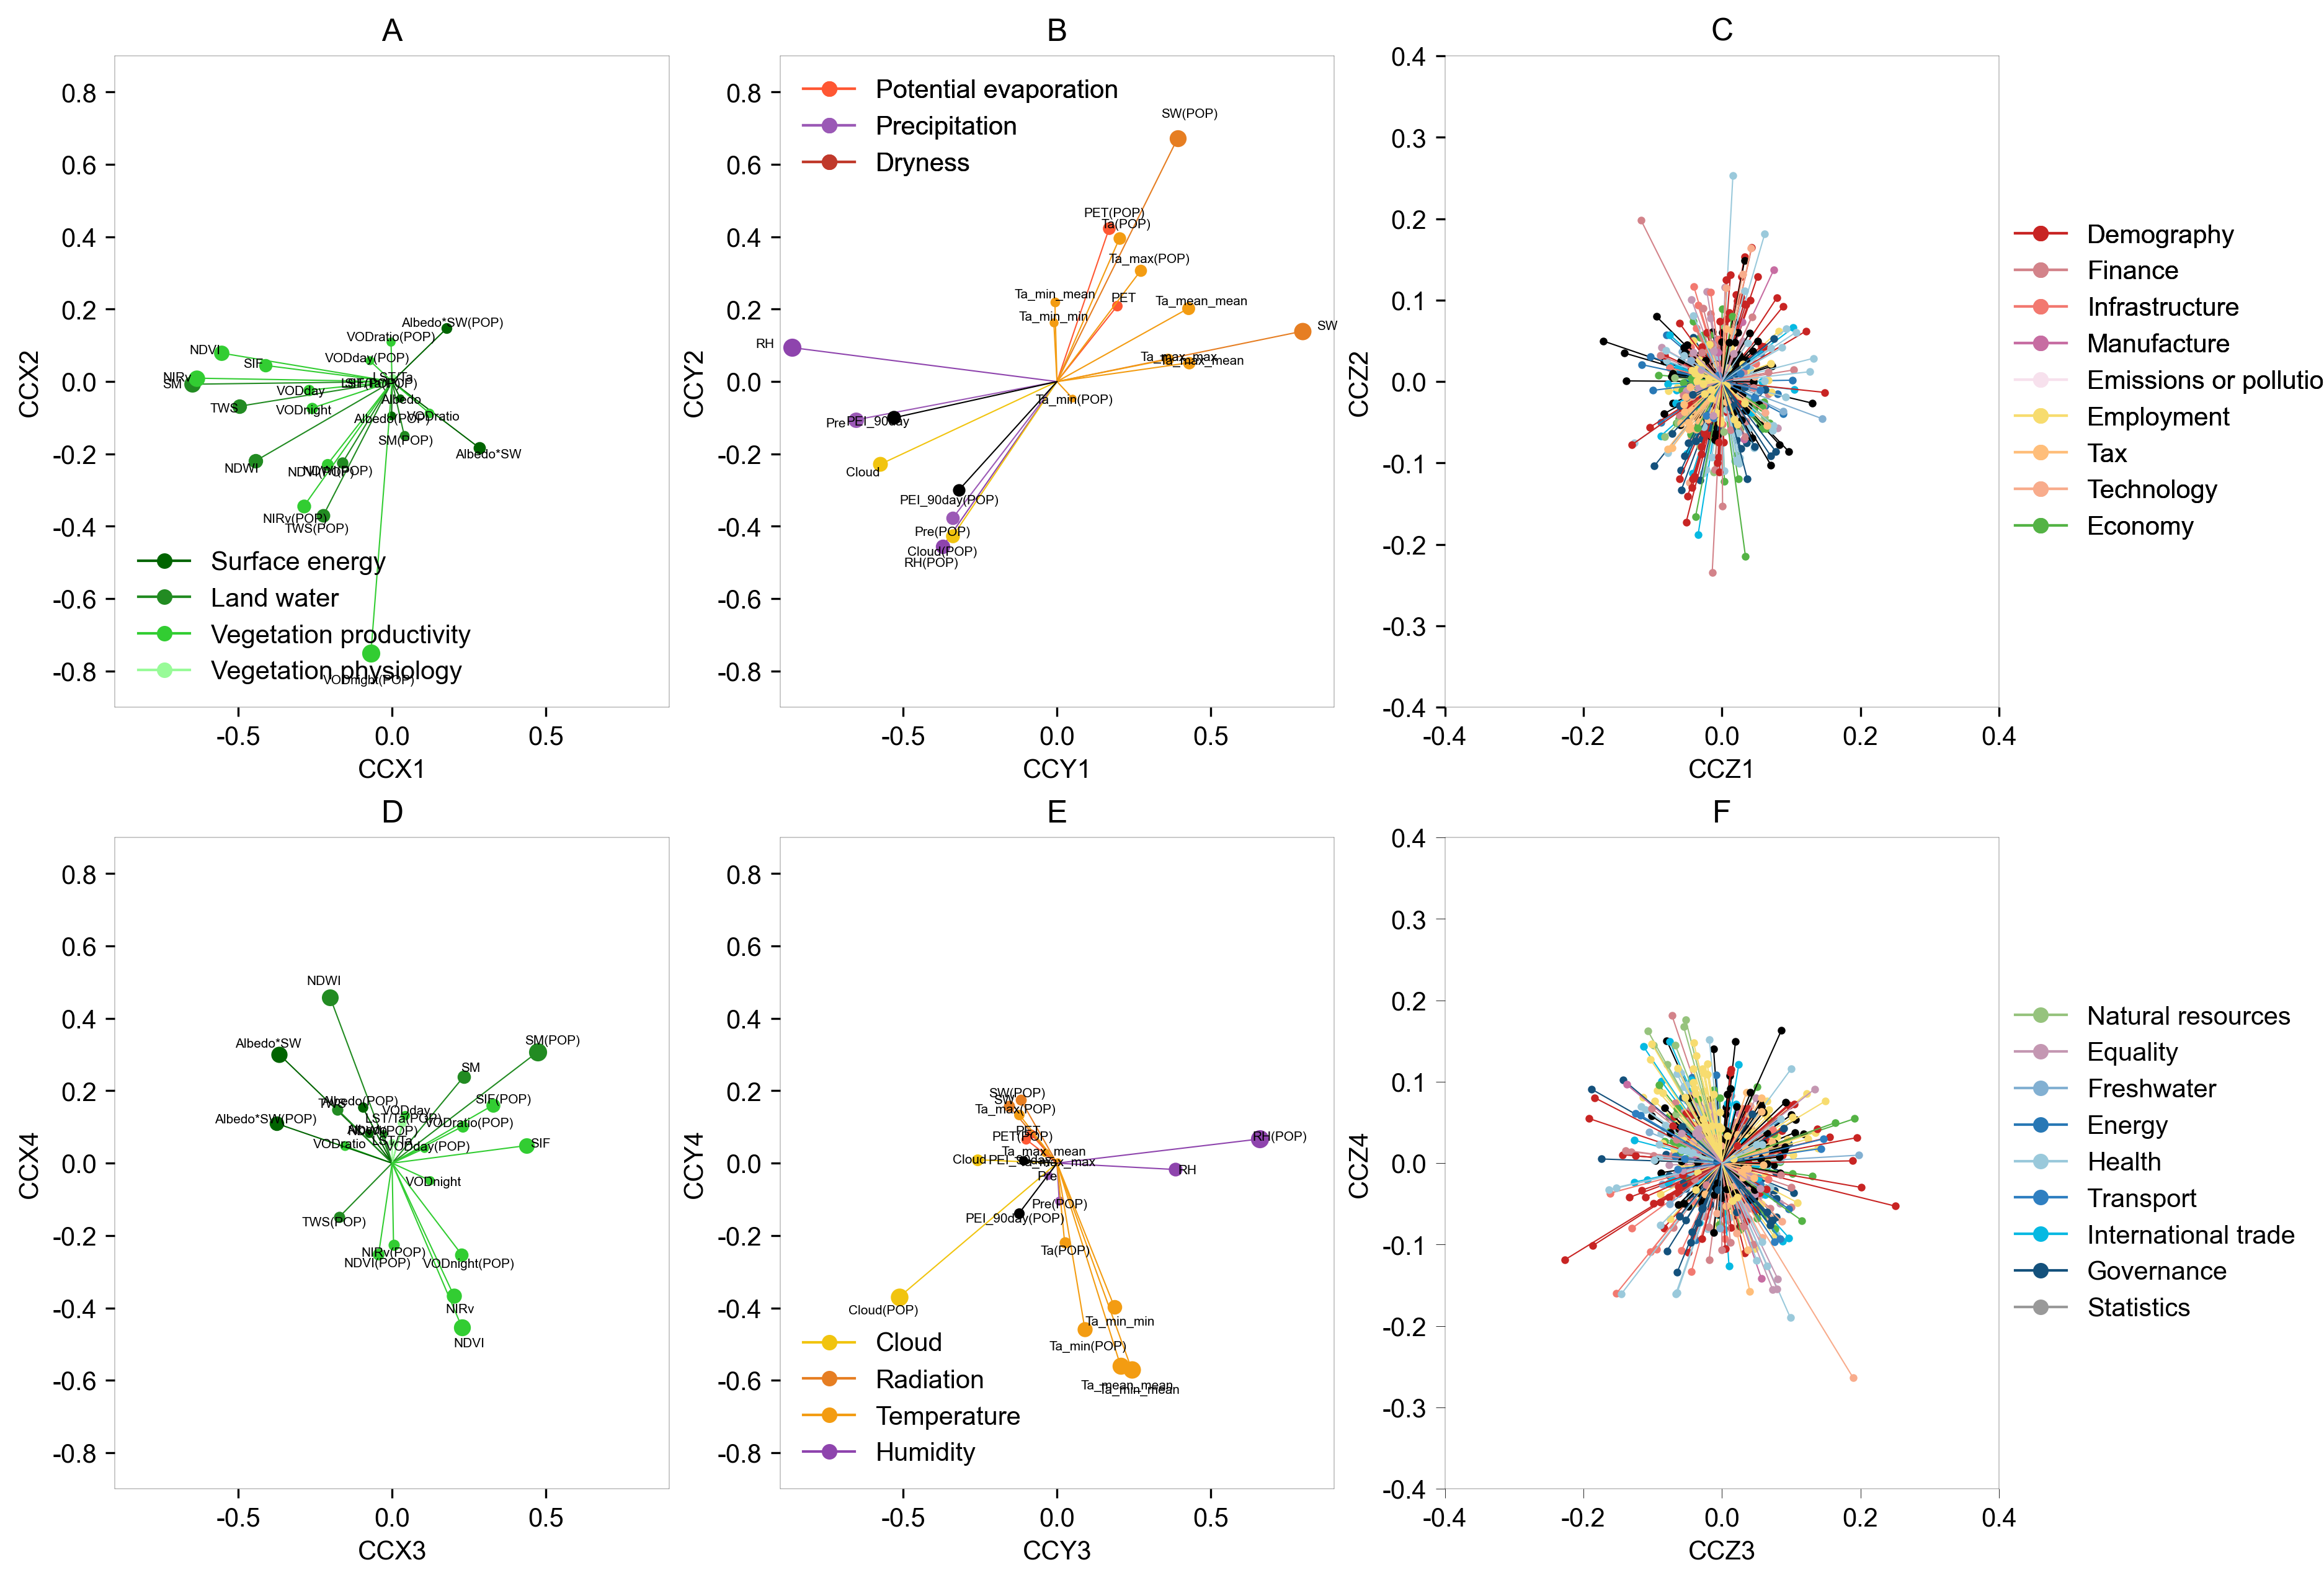

<Figure size 640x480 with 0 Axes>

In [ ]:
#### plotting

df1 = corr_df1.copy()
df2 = corr_df2.copy()
df3 = corr_df3.copy()
centroid_df = df3.groupby('class')[['CCZ1', 'CCZ2', 'CCZ3', 'CCZ4']].mean()

plt.rcParams.update({'font.size': 10})

# Updated classify_feature function based on the dataset
def classify_feature(feature, idx):
    if idx == 0:
        if pd.Series(feature).str.contains("Albedo").any():
            return "Surface energy"
        elif pd.Series(feature).str.contains("SM|NDWI|TWS").any():
            return "Land water"
        elif pd.Series(feature).str.contains("NDVI|NIRv|SIF|VOD").any():
            return "Vegetation productivity"
        elif pd.Series(feature).str.contains("LST/Ta|VOD_ratio").any():
            return "Vegetation physiology"
        else:
            return np.nan

    elif idx == 1:
        if pd.Series(feature).str.contains("PET").any():
            return "Potential evaporation"
        elif pd.Series(feature).str.contains("Pre").any():
            return "Precipitation"
        elif pd.Series(feature).str.contains("PEI|PEI_90day").any():
            return "Drought index"
        elif pd.Series(feature).str.contains("Cloud").any():
            return "Cloud"
        elif pd.Series(feature).str.contains("SW").any():
            return "Radiation"
        elif pd.Series(feature).str.contains("Ta").any():
            return "Temperature"
        elif pd.Series(feature).str.contains("RH").any():
            return "Humidity"
        else:
            return np.nan

# Function to plot 2D loadings with normalized sizes for multiple datasets
def plot_2d_loadings_with_normalized_sizes_multiple(df_list, components, titles):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

    for idy, compo in enumerate(components):
        for idx, df in enumerate(df_list):
            if 'newname' not in df.columns:
                df.rename(columns={'Unnamed: 0': 'newname'}, inplace=True)
            
            if idx < 2:  # Only classify for df1 and df2
                df['classification'] = df['newname'].apply(lambda x: classify_feature(x, idx))
            else:  # For df3, use the existing 'class' column
                df['classification'] = df['class']
                
            ax = axes[idy,idx]
            component1, component2 = components[idy][idx]
            title = titles[idy][idx]
    
            # Define feature colors according to each dataset
            if idx == 0:
                feature_colors = {
                    "Surface energy": "#006400",          # Dark Green
                    "Land water": "#228B22",              # Forest Green
                    "Vegetation productivity": "#32CD32", # Lime Green
                    "Vegetation physiology": "#98FB98"    # Pale Green
                }
            elif idx == 1:
                feature_colors = {
                    "Potential evaporation": "#FF5733",  # Red-Orange (associated with high heat)
                    "Precipitation": "#9B59B6",          # Purple (associated with clouds and rain)
                    "Dryness": "#C0392B",                # Dark Red (dry, intense heat)
                    "Cloud": "#F1C40F",                  # Bright Yellow (sunlight breaking through clouds)
                    "Radiation": "#E67E22",              # Orange (heat and radiation)
                    "Temperature": "#F39C12",            # Bright Yellow-Orange (hot temperatures)
                    "Humidity": "#8E44AD"                # Purple (associated with moisture in the air)
                }
            elif idx == 2:
                feature_colors = {  
                    # Reds and pinks
                    'Demography': '#C82423',      # Red
                    'Finance': '#D3838A',         # Pinkish red
                    'Infrastructure': '#F27970',  # Light red-orange
                    'Manufacture': '#C76DA2',     # Pinkish
                    'Emissions or pollution': '#F7E1ED',  # Light pink
                    
                    # Oranges and yellows
                    'Employment': '#F7DC6F',      # Yellow
                    'Tax': '#FFBE7A',             # Yellow-Orange
                    'Technology': '#F8AC8C',      # Peach
                    
                    # Greens
                    'Economy': '#54B345',         # Green
                    'Natural resources': '#96C37D',  # Light Green
                    'Equality': '#C497B2',        # Light Purple with green undertone
                    
                    # Blues
                    'Freshwater': '#82B0D2',      # Light Blue
                    'Energy': '#2878B5',          # Blue
                    'Health': '#9AC9DB',          # Light blue
                    'Transport': '#2F7FC1',       # Bright Blue
                    'International trade': '#05B9E2', # Cyan/Blue
                    
                    # Darker tones and gray
                    'Governance': '#14517C',      # Dark blue
                    'Statistics': '#999999'       # Gray
                }        
                
            # Compute the lengths of each line
            lengths = np.sqrt(df[component1]**2 + df[component2]**2)
    
            # Normalize the lengths to a range for scaling circle sizes (e.g., between 20 and 60)
            min_size, max_size = 20, [60,60,20][idx]
            norm_lengths = (lengths - lengths.min()) / (lengths.max() - lengths.min()) * (max_size - min_size) + min_size
    
            # Keep track of plotted classifications to avoid duplicates in the legend
            plotted_classes = set()
    
            # Plot each arrow with a circle marker and color based on feature classification
            for i in range(len(df)):
                x = df[component1].iloc[i]
                y = df[component2].iloc[i]
                
                # Get the feature classification for coloring
                feature_class = df['classification'].iloc[i]
                color = feature_colors.get(feature_class, 'black')  # Default to black if not classified
                
                # Plot the line from the origin to the point
                ax.plot([0, x], [0, y], color=color, lw=0.5)  # Line without arrowheads
                
                # Plot a circle marker at the end of the line, size scaled by normalized line length
                ax.plot(x, y, marker='o', markersize=norm_lengths.iloc[i]*0.1, color=color)
    
                # Add to the legend only if this feature class hasn't been added yet
                if feature_class not in plotted_classes:
                    ax.plot([], [], marker='o', color=color, label=feature_class, lw=0)
                    plotted_classes.add(feature_class)
    
                # Check if it's df3, if so, use 'class' for text labels, otherwise use 'newname'
                if idx == 2:
                    # label_text = df['newname'].iloc[i]
                    # label_text = df['class'].iloc[i]
                    label_text = ''
                else:
                    label_text = df['newname'].iloc[i]
    
                # Adding text labels near the circle marker
                ax.text(x * 1.1, y * 1.1, label_text, fontsize=5, ha='center', va='center')
    
            # Customize each subplot
            ax.set_facecolor('white')
            ax.grid(False)
            if idx<2:
                ax.set_xlim(-0.9, 0.9)
                ax.set_ylim(-0.9, 0.9)
            else:
                ax.set_xlim(-0.4, 0.4)
                ax.set_ylim(-0.4, 0.4)    
            ax.set_xlabel(component1)
            ax.set_ylabel(component2)
            ax.set_title(title)
    
            # Custom legend using Line2D with both line and dot at the right end of the line
            if idx == 0:
                legend_elements = [
                    Line2D([0, 1], [0, 0], color="#006400", lw=1, marker='o', markersize=5, markerfacecolor="#006400", markeredgecolor="#006400", label="Surface energy"),
                    Line2D([0, 1], [0, 0], color="#228B22", lw=1, marker='o', markersize=5, markerfacecolor="#228B22", markeredgecolor="#228B22", label="Land water"),
                    Line2D([0, 1], [0, 0], color="#32CD32", lw=1, marker='o', markersize=5, markerfacecolor="#32CD32", markeredgecolor="#32CD32", label="Vegetation productivity"),
                    Line2D([0, 1], [0, 0], color="#98FB98", lw=1, marker='o', markersize=5, markerfacecolor="#98FB98", markeredgecolor="#98FB98", label="Vegetation physiology")
                ]
                if idy==0:
                    ax.legend(handles=legend_elements, loc='lower left', frameon=False)
            if idx == 1:
                legend_elements = [
                    Line2D([0, 1], [0, 0], color='#FF5733', lw=1, marker='o', markersize=5, markerfacecolor='#FF5733', markeredgecolor='#FF5733', label="Potential evaporation"),  # Red-Orange
                    Line2D([0, 1], [0, 0], color='#9B59B6', lw=1, marker='o', markersize=5, markerfacecolor='#9B59B6', markeredgecolor='#9B59B6', label="Precipitation"),  # Purple
                    Line2D([0, 1], [0, 0], color='#C0392B', lw=1, marker='o', markersize=5, markerfacecolor='#C0392B', markeredgecolor='#C0392B', label="Dryness"),  # Dark Red
                    Line2D([0, 1], [0, 0], color='#F1C40F', lw=1, marker='o', markersize=5, markerfacecolor='#F1C40F', markeredgecolor='#F1C40F', label="Cloud"),  # Bright Yellow
                    Line2D([0, 1], [0, 0], color='#E67E22', lw=1, marker='o', markersize=5, markerfacecolor='#E67E22', markeredgecolor='#E67E22', label="Radiation"),  # Orange
                    Line2D([0, 1], [0, 0], color='#F39C12', lw=1, marker='o', markersize=5, markerfacecolor='#F39C12', markeredgecolor='#F39C12', label="Temperature"),  # Bright Yellow-Orange
                    Line2D([0, 1], [0, 0], color='#8E44AD', lw=1, marker='o', markersize=5, markerfacecolor='#8E44AD', markeredgecolor='#8E44AD', label="Humidity")  # Purple
                ]
                if idy==0:
                    # Split legend_elements into two groups
                    legend_elements_group1 = legend_elements[:len(legend_elements) // 2]  # First half
                    
                    # First legend in the upper left (ncol=1, or adjust as needed)
                    legend1 = ax.legend(handles=legend_elements_group1, loc='upper left', frameon=False, ncol=1)
                    
                    # Add the first legend manually
                    ax.add_artist(legend1)
                if idy==1:
                    # Second legend in the lower right (ncol=1, or adjust as needed)
                    legend_elements_group2 = legend_elements[len(legend_elements) // 2:]  # Second half
                    ax.legend(handles=legend_elements_group2, loc='lower left', frameon=False, ncol=1)
                
            if idx == 2:
                legend_elements = [
                    # Reds and pinks
                    Line2D([0, 1], [0, 0], color='#C82423', lw=1, marker='o', markersize=5, markerfacecolor='#C82423', markeredgecolor='#C82423', label="Demography"),  # Red
                    Line2D([0, 1], [0, 0], color='#D3838A', lw=1, marker='o', markersize=5, markerfacecolor='#D3838A', markeredgecolor='#D3838A', label="Finance"),  # Pinkish red
                    Line2D([0, 1], [0, 0], color='#F27970', lw=1, marker='o', markersize=5, markerfacecolor='#F27970', markeredgecolor='#F27970', label="Infrastructure"),  # Light red-orange
                    Line2D([0, 1], [0, 0], color='#C76DA2', lw=1, marker='o', markersize=5, markerfacecolor='#C76DA2', markeredgecolor='#C76DA2', label="Manufacture"),  # Pinkish
                    Line2D([0, 1], [0, 0], color='#F7E1ED', lw=1, marker='o', markersize=5, markerfacecolor='#F7E1ED', markeredgecolor='#F7E1ED', label="Emissions or pollution"),  # Light pink
                    
                    # Oranges and yellows
                    Line2D([0, 1], [0, 0], color='#F7DC6F', lw=1, marker='o', markersize=5, markerfacecolor='#F7DC6F', markeredgecolor='#F7DC6F', label="Employment"),  # Yellow
                    Line2D([0, 1], [0, 0], color='#FFBE7A', lw=1, marker='o', markersize=5, markerfacecolor='#FFBE7A', markeredgecolor='#FFBE7A', label="Tax"),  # Yellow-Orange
                    Line2D([0, 1], [0, 0], color='#F8AC8C', lw=1, marker='o', markersize=5, markerfacecolor='#F8AC8C', markeredgecolor='#F8AC8C', label="Technology"),  # Peach
                    
                    # Greens
                    Line2D([0, 1], [0, 0], color='#54B345', lw=1, marker='o', markersize=5, markerfacecolor='#54B345', markeredgecolor='#54B345', label="Economy"),  # Green
                    Line2D([0, 1], [0, 0], color='#96C37D', lw=1, marker='o', markersize=5, markerfacecolor='#96C37D', markeredgecolor='#96C37D', label="Natural resources"),  # Light Green
                    Line2D([0, 1], [0, 0], color='#C497B2', lw=1, marker='o', markersize=5, markerfacecolor='#C497B2', markeredgecolor='#C497B2', label="Equality"),  # Light Purple with green undertone
                    
                    # Blues
                    Line2D([0, 1], [0, 0], color='#82B0D2', lw=1, marker='o', markersize=5, markerfacecolor='#82B0D2', markeredgecolor='#82B0D2', label="Freshwater"),  # Light Blue
                    Line2D([0, 1], [0, 0], color='#2878B5', lw=1, marker='o', markersize=5, markerfacecolor='#2878B5', markeredgecolor='#2878B5', label="Energy"),  # Blue
                    Line2D([0, 1], [0, 0], color='#9AC9DB', lw=1, marker='o', markersize=5, markerfacecolor='#9AC9DB', markeredgecolor='#9AC9DB', label="Health"),  # Light blue
                    Line2D([0, 1], [0, 0], color='#2F7FC1', lw=1, marker='o', markersize=5, markerfacecolor='#2F7FC1', markeredgecolor='#2F7FC1', label="Transport"),  # Bright Blue
                    Line2D([0, 1], [0, 0], color='#05B9E2', lw=1, marker='o', markersize=5, markerfacecolor='#05B9E2', markeredgecolor='#05B9E2', label="International trade"),  # Cyan/Blue
                    
                    # Darker tones and gray
                    Line2D([0, 1], [0, 0], color='#14517C', lw=1, marker='o', markersize=5, markerfacecolor='#14517C', markeredgecolor='#14517C', label="Governance"),  # Dark blue
                    Line2D([0, 1], [0, 0], color='#999999', lw=1, marker='o', markersize=5, markerfacecolor='#999999', markeredgecolor='#999999', label="Statistics")  # Gray
                ]

                if idy==0:
                    # Split legend_elements into two groups
                    legend_elements_group1 = legend_elements[:len(legend_elements) // 2]  # First half
                    
                    # First legend in the upper left (ncol=1, or adjust as needed)
                    legend1 = ax.legend(handles=legend_elements_group1, loc='center left', frameon=False, bbox_to_anchor=(1.01, 0.5), borderaxespad=0, ncol=1)
                    
                    # Add the first legend manually
                    ax.add_artist(legend1)
                if idy==1:
                    # Second legend in the lower right (ncol=1, or adjust as needed)
                    legend_elements_group2 = legend_elements[len(legend_elements) // 2:]  # Second half
                    ax.legend(handles=legend_elements_group2, loc='center left', frameon=False, bbox_to_anchor=(1.01, 0.5), borderaxespad=0, ncol=1)
            
            plt.setp(ax.spines.values(), lw=0.1)
            plt.tick_params(axis='x', width=0.2)  # Set width for x-axis ticks
            plt.tick_params(axis='y', width=0.2)  # Set width for x-axis ticks             
    # Adjust layout to prevent overlap
    plt.subplots_adjust(right=0.8)  # Adjust the right margin to accommodate the legend
    return(plt)

df_list = [df1, df2, df3]
components = [[('CCX1', 'CCX2'), ('CCY1', 'CCY2'), ('CCZ1', 'CCZ2')],
              [('CCX3', 'CCX4'), ('CCY3', 'CCY4'), ('CCZ3', 'CCZ4')]]
titles = [['A','B','C'],
         ['D','E','F']]

plot_2d_loadings_with_normalized_sizes_multiple(df_list, components, titles)
plt.show()
# plt.savefig(data_path('figure/fig1.variable_loading_all.jpg'), bbox_inches='tight')


# Manuscript Figure 4: Similar to above figure but simplifying labels of variables

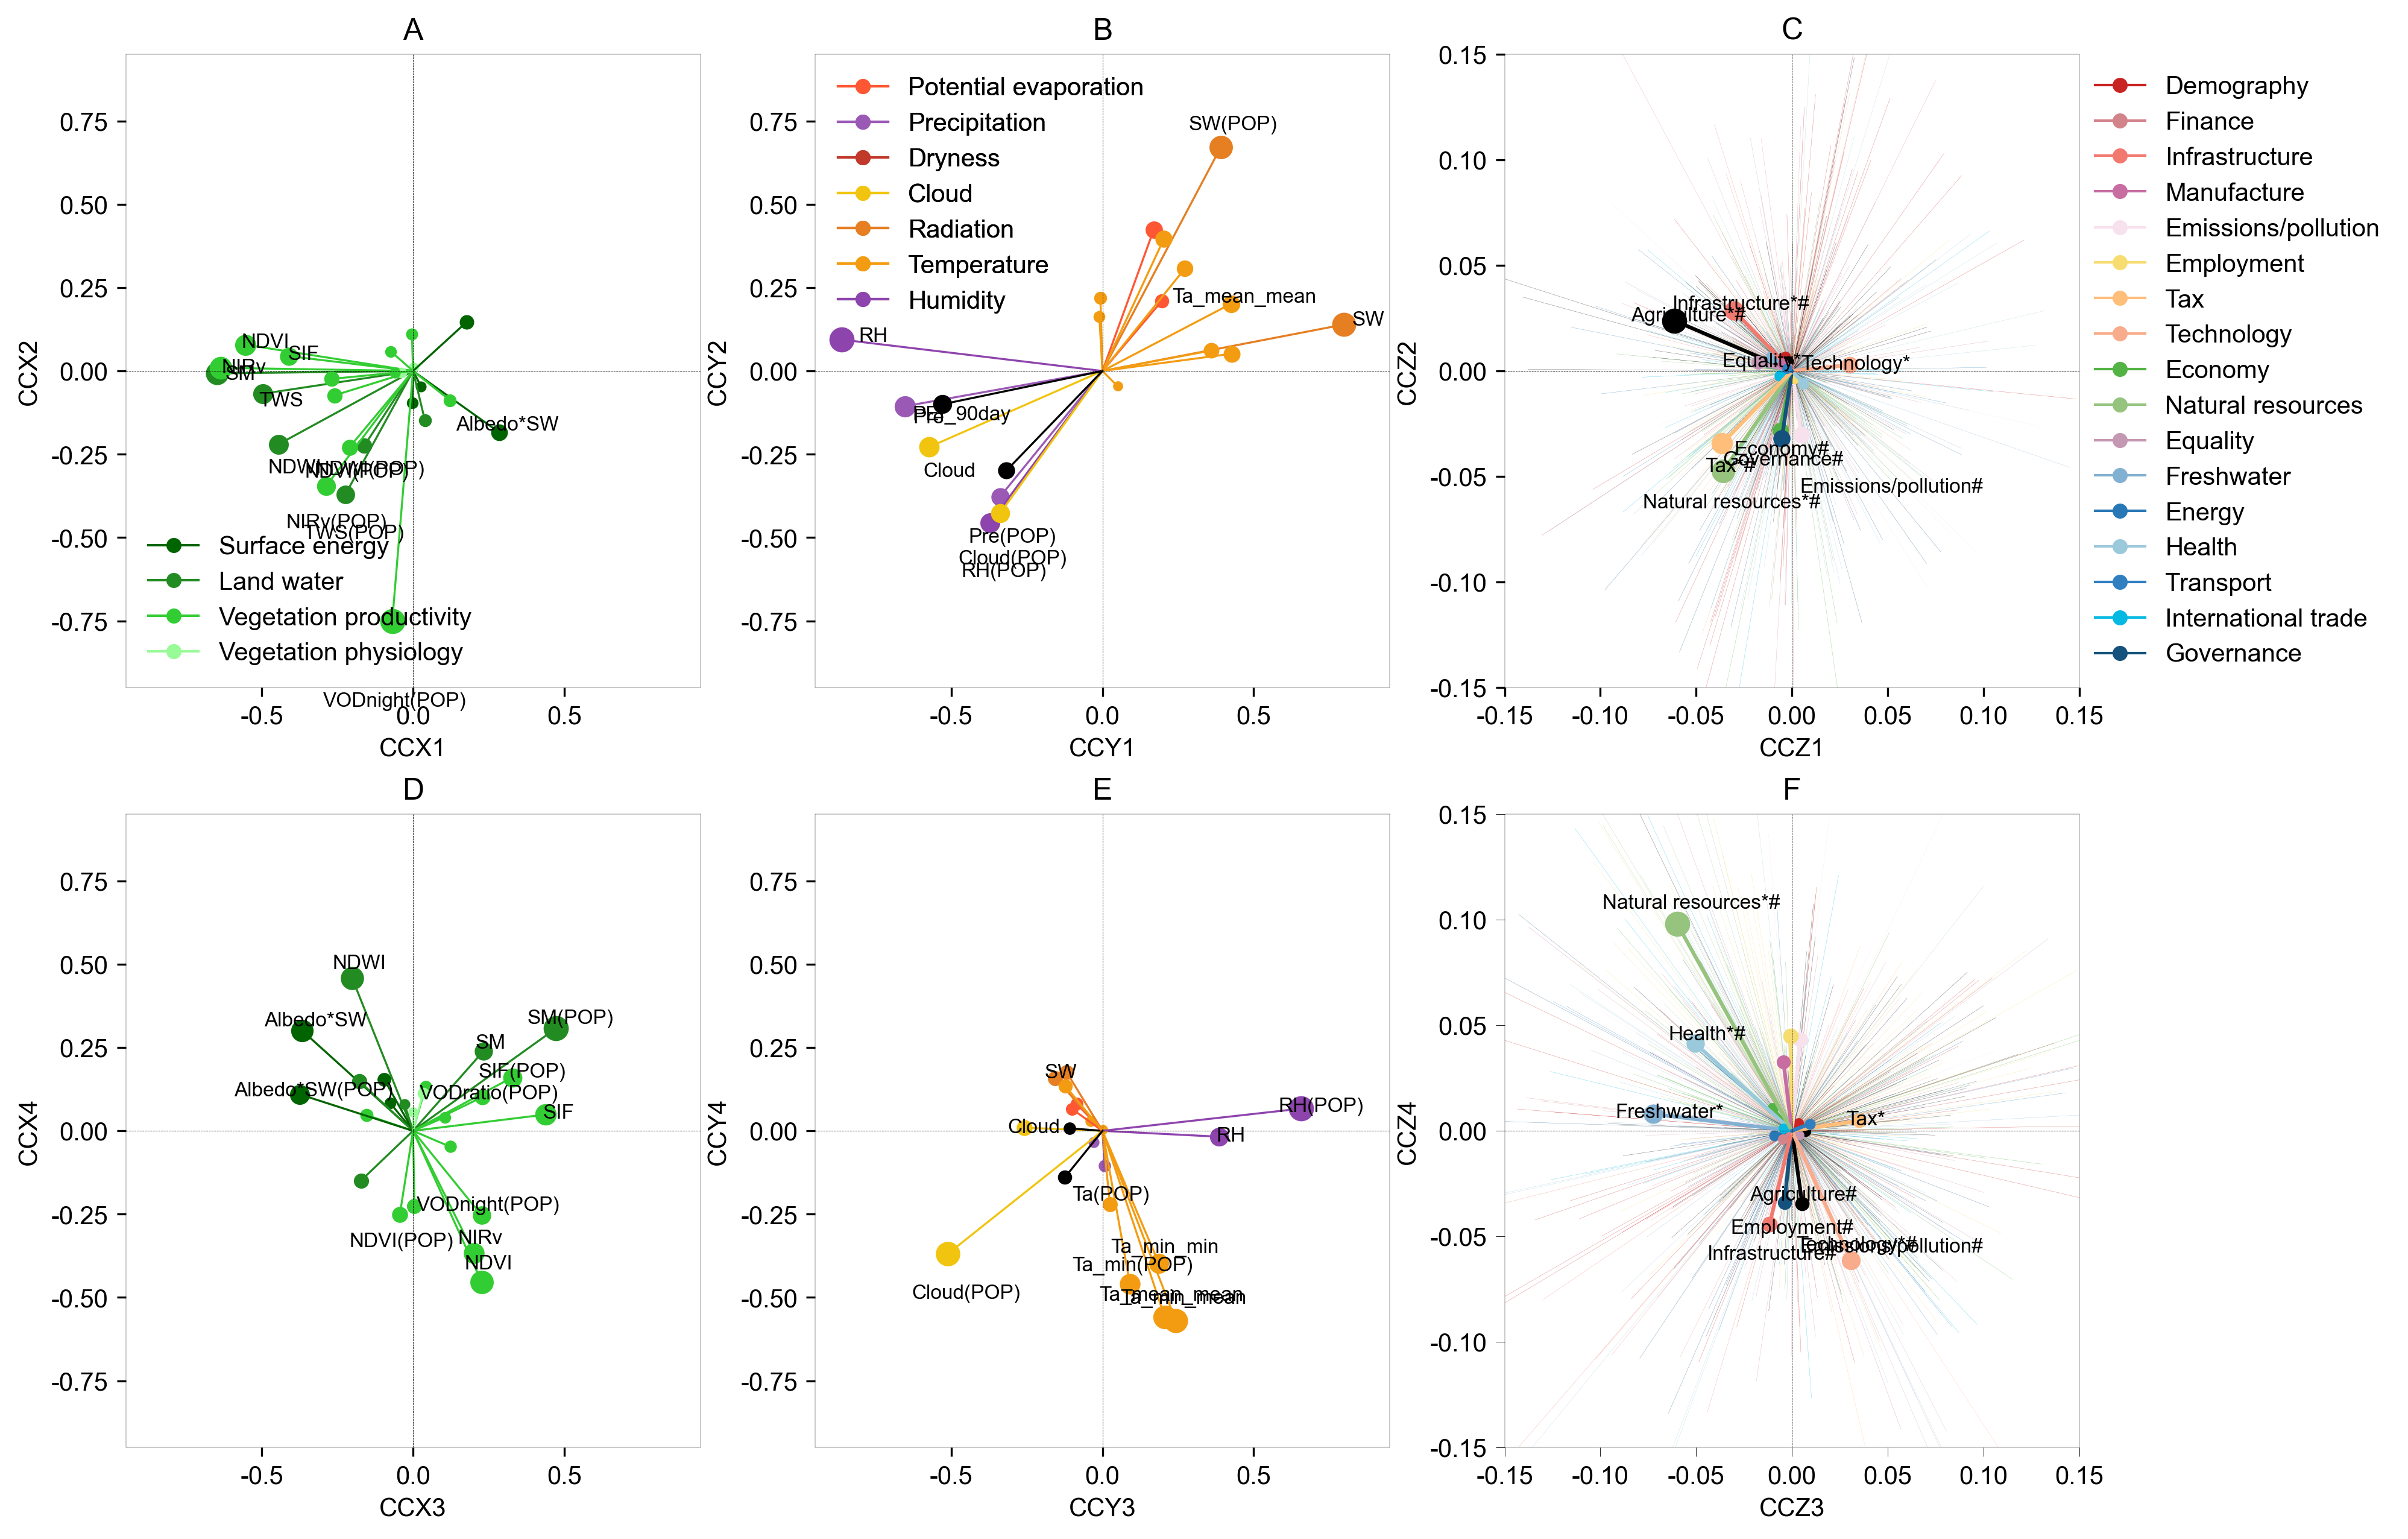

In [ ]:
df1 = corr_df1.copy()
df2 = corr_df2.copy()
df3 = corr_df3.copy()

# Step 1: Calculate the mean of the absolute values for CCZ1, CCZ2, CCZ3, and CCZ4
centroid_abs_df = df3.groupby('class')[['CCZ1', 'CCZ2', 'CCZ3', 'CCZ4']].apply(lambda x: x.abs().median())

# Step 2: Determine the direction for each class and adjust even for "Not Significant"
def assign_direction_and_flag(group):
    directions = {}
    
    for col in ['CCZ1', 'CCZ2', 'CCZ3', 'CCZ4']:
        # Calculate the proportion of positive values in the group
        pos_proportion = (group[col] > 0).mean()
        neg_proportion = (group[col] < 0).mean()

        # If more than 2/3 are positive or negative, assign full direction
        if pos_proportion > 2/3:
            directions[col] = 1  # Strong positive direction
        elif neg_proportion > 2/3:
            directions[col] = -1  # Strong negative direction
        else:
            # If not significant, assign a reduced direction based on majority
            directions[col] = pos_proportion - neg_proportion  # Net positive or negative effect
    
    return pd.Series(directions)

# Step 3: Apply the direction assignment for each class
directions_df = df3.groupby('class').apply(assign_direction_and_flag)

# Step 4: Multiply the absolute centroids by the assigned directions to restore the sign and adjust the not significant ones
for col in ['CCZ1', 'CCZ2', 'CCZ3', 'CCZ4']:
    centroid_abs_df[col] = centroid_abs_df[col] * directions_df[col]

# Step 5: Add a separate significance flag for each column (CCZ1, CCZ2, CCZ3, CCZ4)
significance_df = df3.groupby('class').apply(lambda group: pd.Series({
    'CCZ1_flag': 1 if (group['CCZ1'] > 0).mean() > 2/3 or (group['CCZ1'] < 0).mean() > 2/3 else 0,
    'CCZ2_flag': 1 if (group['CCZ2'] > 0).mean() > 2/3 or (group['CCZ2'] < 0).mean() > 2/3 else 0,
    'CCZ3_flag': 1 if (group['CCZ3'] > 0).mean() > 2/3 or (group['CCZ3'] < 0).mean() > 2/3 else 0,
    'CCZ4_flag': 1 if (group['CCZ4'] > 0).mean() > 2/3 or (group['CCZ4'] < 0).mean() > 2/3 else 0
}))

# Add the flags to the centroid dataframe
centroid_abs_df = centroid_abs_df.join(significance_df)
centroid_abs_df



df1, df2, df3 = corr_df1, corr_df2, corr_df3

plt.rcParams.update({'font.size': 10})

# Simplified classify_feature function
def classify_feature(feature, idx):
    patterns = [
        (["Albedo"], "Surface energy"),
        (["SM", "NDWI", "TWS"], "Land water"),
        (["NDVI", "NIRv", "SIF", "VOD"], "Vegetation productivity"),
        (["LST/Ta", "VOD_ratio"], "Vegetation physiology")
    ]
    patterns_idx_1 = [
        (["PET"], "Potential evaporation"),
        (["Pre"], "Precipitation"),
        (["PEI", "PEI_90day"], "Drought index"),
        (["Cloud"], "Cloud"),
        (["SW"], "Radiation"),
        (["Ta"], "Temperature"),
        (["RH"], "Humidity")
    ]
    
    feature_patterns = patterns if idx == 0 else patterns_idx_1
    
    for keys, label in feature_patterns:
        if pd.Series(feature).str.contains('|'.join(keys)).any():
            return label
    return np.nan

# Function to dynamically adjust text position based on feature coordinates
def adjust_text_position(x, y, factor=1.5):
    """Adjusts text position slightly to avoid overlap based on coordinate values."""
    if x > 0 and y > 0:  # Quadrant I
        return x * factor, y * factor
    elif x < 0 and y > 0:  # Quadrant II
        return x * factor * 0.8, y * factor
    elif x < 0 and y < 0:  # Quadrant III
        return x * factor * 0.8, y * factor * 1.2
    elif x > 0 and y < 0:  # Quadrant IV
        return x * factor, y * factor * 0.8
    else:
        return x * factor, y * factor

        
# Function to plot 2D loadings
def plot_2d_loadings_with_normalized_sizes_multiple(df_list, components, titles):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=300)

    feature_colors_all = [
        {
            "Surface energy": "#006400", "Land water": "#228B22", "Vegetation productivity": "#32CD32", "Vegetation physiology": "#98FB98"
        },
        {
            "Potential evaporation": "#FF5733", "Precipitation": "#9B59B6", "Dryness": "#C0392B", "Cloud": "#F1C40F",
            "Radiation": "#E67E22", "Temperature": "#F39C12", "Humidity": "#8E44AD"
        },
        {
            'Demography': '#C82423', 'Finance': '#D3838A', 'Infrastructure': '#F27970', 'Manufacture': '#C76DA2',
            "Emissions/pollution": '#F7E1ED', 'Employment': '#F7DC6F', 'Tax': '#FFBE7A', 'Technology': '#F8AC8C',
            'Economy': '#54B345', 'Natural resources': '#96C37D', 'Equality': '#C497B2', 'Freshwater': '#82B0D2',
            'Energy': '#2878B5', 'Health': '#9AC9DB', 'Transport': '#2F7FC1', 'International trade': '#05B9E2',
            'Governance': '#14517C'
        }
    ]
    
    for idy, compo in enumerate(components[:2]):
        for idx, df in enumerate(df_list):
            if 'newname' not in df.columns:
                df.rename(columns={'Unnamed: 0': 'newname'}, inplace=True)
            
            if idx < 2:
                df['classification'] = df['newname'].apply(lambda x: classify_feature(x, idx))
            else:
                df['classification'] = df['class']
            
            ax = axes[idy, idx]
            component1, component2 = components[idy][idx]
            title = titles[idy][idx]

            # Assign color based on feature classification
            feature_colors = feature_colors_all[idx]
            
            lengths = np.sqrt(df[component1] ** 2 + df[component2] ** 2)
            norm_lengths = np.interp(lengths, (lengths.min(), lengths.max()), (20, 60))
    
            for i in range(len(df)):
                x, y = df[component1].iloc[i], df[component2].iloc[i]
                color = feature_colors.get(df['classification'].iloc[i], 'black')
                
                # Plot main lines and markers with your specified styles
                ax.plot([0, x], [0, y], color=color, lw=0.8 if idx < 2 else 0.1, alpha=0.6 if idx == 2 else 1)
                if idx<2:
                    ax.plot(x, y, 'o', markersize=norm_lengths[i] * 0.15, color=color)
                
                # Add text labels to df1 and df2 points
                if idx != 2:
                    if lengths[i] > np.nanpercentile(lengths, 50):
                        adj_x, adj_y = adjust_text_position(x, y, factor=1.1)
                        ax.text(adj_x, adj_y, df['newname'].iloc[i], fontsize=8, ha='center', va='center')

            # Add centroid lines for df3
            if idx == 2:
                component3, component4 = ['CCZ1', 'CCZ3'][idy], ['CCZ2', 'CCZ4'][idy]
                centroid_x = centroid_abs_df[component3]
                centroid_y = centroid_abs_df[component4]
                centroid_lengths = np.sqrt(centroid_x ** 2 + centroid_y ** 2)
                norm_centroid_lengths = np.interp(centroid_lengths, (centroid_lengths.min(), centroid_lengths.max()), (20, 60))
                
                for i in range(len(centroid_x)):
                    cx, cy = centroid_x.iloc[i], centroid_y.iloc[i]
                    centroid_class = centroid_x.index[i]
                    color = feature_colors.get(centroid_class, 'black')
                    
                    # Plot main centroid lines and markers as specified
                    ax.plot([0, cx], [0, cy], color=color, lw=1.5)
                    ax.plot(cx, cy, 'o', markersize=norm_centroid_lengths[i] * 0.15, color=color)
                    
                    # Add labels to the centroids based on your rules
                    if centroid_lengths[i] > np.nanpercentile(centroid_lengths, 50):
                        label_text = centroid_class
                        adj_x, adj_y = adjust_text_position(cx, cy, factor=1.1)
                        if label_text == 'Employment':
                            adj_x, adj_y = 0,-0.046
                        if label_text == 'Emissions/pollution':
                            adj_x, adj_y = 0.052,-0.055
                        if centroid_abs_df[f'{component3}_flag'][i] == 1 and centroid_abs_df[f'{component4}_flag'][i] == 1:
                            label_text += '*#'
                        elif centroid_abs_df[f'{component3}_flag'][i] == 1 and centroid_abs_df[f'{component4}_flag'][i] != 1:
                            label_text += '*'
                        if centroid_abs_df[f'{component3}_flag'][i] != 1 and centroid_abs_df[f'{component4}_flag'][i] == 1:
                            label_text += '#'
                        elif centroid_abs_df[f'{component3}_flag'][i] != 1 and centroid_abs_df[f'{component4}_flag'][i] != 1:
                            label_text += ''
                        ax.text(adj_x, adj_y, label_text, fontsize=8, ha='center', va='center')
                        
            ax.set_xlim(-0.95 if idx < 2 else -0.15, 0.95 if idx < 2 else 0.15)
            ax.set_ylim(-0.95 if idx < 2 else -0.15, 0.95 if idx < 2 else 0.15)
            ax.set_xlabel(component1)
            ax.set_ylabel(component2)
            ax.set_title(title)

            # Add legends based on the dataset and plot position
            if idx == 0:  # Legend for df1
                legend_elements = [
                    Line2D([0, 1], [0, 0], color="#006400", lw=1, marker='o', markersize=5, markerfacecolor="#006400", markeredgecolor="#006400", label="Surface energy"),
                    Line2D([0, 1], [0, 0], color="#228B22", lw=1, marker='o', markersize=5, markerfacecolor="#228B22", markeredgecolor="#228B22", label="Land water"),
                    Line2D([0, 1], [0, 0], color="#32CD32", lw=1, marker='o', markersize=5, markerfacecolor="#32CD32", markeredgecolor="#32CD32", label="Vegetation productivity"),
                    Line2D([0, 1], [0, 0], color="#98FB98", lw=1, marker='o', markersize=5, markerfacecolor="#98FB98", markeredgecolor="#98FB98", label="Vegetation physiology")
                ]
                if idy == 0:
                    ax.legend(handles=legend_elements, loc='lower left', frameon=False)
            
            if idx == 1:  # Legend for df2
                legend_elements = [
                    Line2D([0, 1], [0, 0], color='#FF5733', lw=1, marker='o', markersize=5, markerfacecolor='#FF5733', markeredgecolor='#FF5733', label="Potential evaporation"),
                    Line2D([0, 1], [0, 0], color='#9B59B6', lw=1, marker='o', markersize=5, markerfacecolor='#9B59B6', markeredgecolor='#9B59B6', label="Precipitation"),
                    Line2D([0, 1], [0, 0], color='#C0392B', lw=1, marker='o', markersize=5, markerfacecolor='#C0392B', markeredgecolor='#C0392B', label="Dryness"),
                    Line2D([0, 1], [0, 0], color='#F1C40F', lw=1, marker='o', markersize=5, markerfacecolor='#F1C40F', markeredgecolor='#F1C40F', label="Cloud"),
                    Line2D([0, 1], [0, 0], color='#E67E22', lw=1, marker='o', markersize=5, markerfacecolor='#E67E22', markeredgecolor='#E67E22', label="Radiation"),
                    Line2D([0, 1], [0, 0], color='#F39C12', lw=1, marker='o', markersize=5, markerfacecolor='#F39C12', markeredgecolor='#F39C12', label="Temperature"),
                    Line2D([0, 1], [0, 0], color='#8E44AD', lw=1, marker='o', markersize=5, markerfacecolor='#8E44AD', markeredgecolor='#8E44AD', label="Humidity")
                ]
                if idy == 0:
                    legend_group1 = legend_elements[:len(legend_elements)]
                    legend1 = ax.legend(handles=legend_group1, loc='upper left', frameon=False)
                    ax.add_artist(legend1)
                    # legend_group1 = legend_elements[:len(legend_elements) // 2]
                    # legend1 = ax.legend(handles=legend_group1, loc='upper left', frameon=False)
                    # ax.add_artist(legend1)
                # if idy == 1:
                #     legend_group2 = legend_elements[len(legend_elements) // 2:]
                #     ax.legend(handles=legend_group2, loc='lower left', frameon=False)
            
            if idx == 2:  # Legend for df3
                legend_elements = [
                    Line2D([0, 1], [0, 0], color='#C82423', lw=1, marker='o', markersize=5, markerfacecolor='#C82423', markeredgecolor='#C82423', label="Demography"),
                    Line2D([0, 1], [0, 0], color='#D3838A', lw=1, marker='o', markersize=5, markerfacecolor='#D3838A', markeredgecolor='#D3838A', label="Finance"),
                    Line2D([0, 1], [0, 0], color='#F27970', lw=1, marker='o', markersize=5, markerfacecolor='#F27970', markeredgecolor='#F27970', label="Infrastructure"),
                    Line2D([0, 1], [0, 0], color='#C76DA2', lw=1, marker='o', markersize=5, markerfacecolor='#C76DA2', markeredgecolor='#C76DA2', label="Manufacture"),
                    Line2D([0, 1], [0, 0], color='#F7E1ED', lw=1, marker='o', markersize=5, markerfacecolor='#F7E1ED', markeredgecolor='#F7E1ED', label="Emissions/pollution"),
                    Line2D([0, 1], [0, 0], color='#F7DC6F', lw=1, marker='o', markersize=5, markerfacecolor='#F7DC6F', markeredgecolor='#F7DC6F', label="Employment"),
                    Line2D([0, 1], [0, 0], color='#FFBE7A', lw=1, marker='o', markersize=5, markerfacecolor='#FFBE7A', markeredgecolor='#FFBE7A', label="Tax"),
                    Line2D([0, 1], [0, 0], color='#F8AC8C', lw=1, marker='o', markersize=5, markerfacecolor='#F8AC8C', markeredgecolor='#F8AC8C', label="Technology"),
                    Line2D([0, 1], [0, 0], color='#54B345', lw=1, marker='o', markersize=5, markerfacecolor='#54B345', markeredgecolor='#54B345', label="Economy"),
                    Line2D([0, 1], [0, 0], color='#96C37D', lw=1, marker='o', markersize=5, markerfacecolor='#96C37D', markeredgecolor='#96C37D', label="Natural resources"),
                    Line2D([0, 1], [0, 0], color='#C497B2', lw=1, marker='o', markersize=5, markerfacecolor='#C497B2', markeredgecolor='#C497B2', label="Equality"),
                    Line2D([0, 1], [0, 0], color='#82B0D2', lw=1, marker='o', markersize=5, markerfacecolor='#82B0D2', markeredgecolor='#82B0D2', label="Freshwater"),
                    Line2D([0, 1], [0, 0], color='#2878B5', lw=1, marker='o', markersize=5, markerfacecolor='#2878B5', markeredgecolor='#2878B5', label="Energy"),
                    Line2D([0, 1], [0, 0], color='#9AC9DB', lw=1, marker='o', markersize=5, markerfacecolor='#9AC9DB', markeredgecolor='#9AC9DB', label="Health"),
                    Line2D([0, 1], [0, 0], color='#2F7FC1', lw=1, marker='o', markersize=5, markerfacecolor='#2F7FC1', markeredgecolor='#2F7FC1', label="Transport"),
                    Line2D([0, 1], [0, 0], color='#05B9E2', lw=1, marker='o', markersize=5, markerfacecolor='#05B9E2', markeredgecolor='#05B9E2', label="International trade"),
                    Line2D([0, 1], [0, 0], color='#14517C', lw=1, marker='o', markersize=5, markerfacecolor='#14517C', markeredgecolor='#14517C', label="Governance"),
                    # Line2D([0, 1], [0, 0], color='#999999', lw=1, marker='o', markersize=5, markerfacecolor='#999999', markeredgecolor='#999999', label="Statistics")
                ]
                if idy == 0:
                    legend_group1 = legend_elements[:len(legend_elements)]
                    ax.legend(handles=legend_group1, loc='center left', frameon=False, bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
                    # legend_group1 = legend_elements[:len(legend_elements) // 2]
                    # ax.legend(handles=legend_group1, loc='center left', frameon=False, bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
                # if idy == 1:
                #     legend_group2 = legend_elements[len(legend_elements) // 2:]
                #     ax.legend(handles=legend_group2, loc='center left', frameon=False, bbox_to_anchor=(1.01, 0.5), borderaxespad=0)

            # Add red lines at x=0 and y=0
            ax.axhline(0, color='black', linewidth=0.2, linestyle='--')  # Horizontal red line at y=0
            ax.axvline(0, color='black', linewidth=0.2, linestyle='--')  # Vertical red line at x=0
            
            plt.setp(ax.spines.values(), lw=0.1)
            plt.tick_params(axis='x', width=0.2)  # Set width for x-axis ticks
            plt.tick_params(axis='y', width=0.2)  # Set width for x-axis ticks             
    # Adjust layout to prevent overlap
    plt.subplots_adjust(right=0.8)  # Adjust the right margin to accommodate the legend
    return(plt)

df_list = [df1, df2, df3]
components = [[('CCX1', 'CCX2'), ('CCY1', 'CCY2'), ('CCZ1', 'CCZ2')],
              [('CCX3', 'CCX4'), ('CCY3', 'CCY4'), ('CCZ3', 'CCZ4')]]
titles = [['A', 'B', 'C'], ['D', 'E', 'F']]

plot_2d_loadings_with_normalized_sizes_multiple(df_list, components, titles)
# plt.savefig(data_path('figure/fig1.variable_loading_all_CCZcentriod.jpg'), bbox_inches='tight')




# Plot D: Trajectories of syndromes across time

1.249200628890744


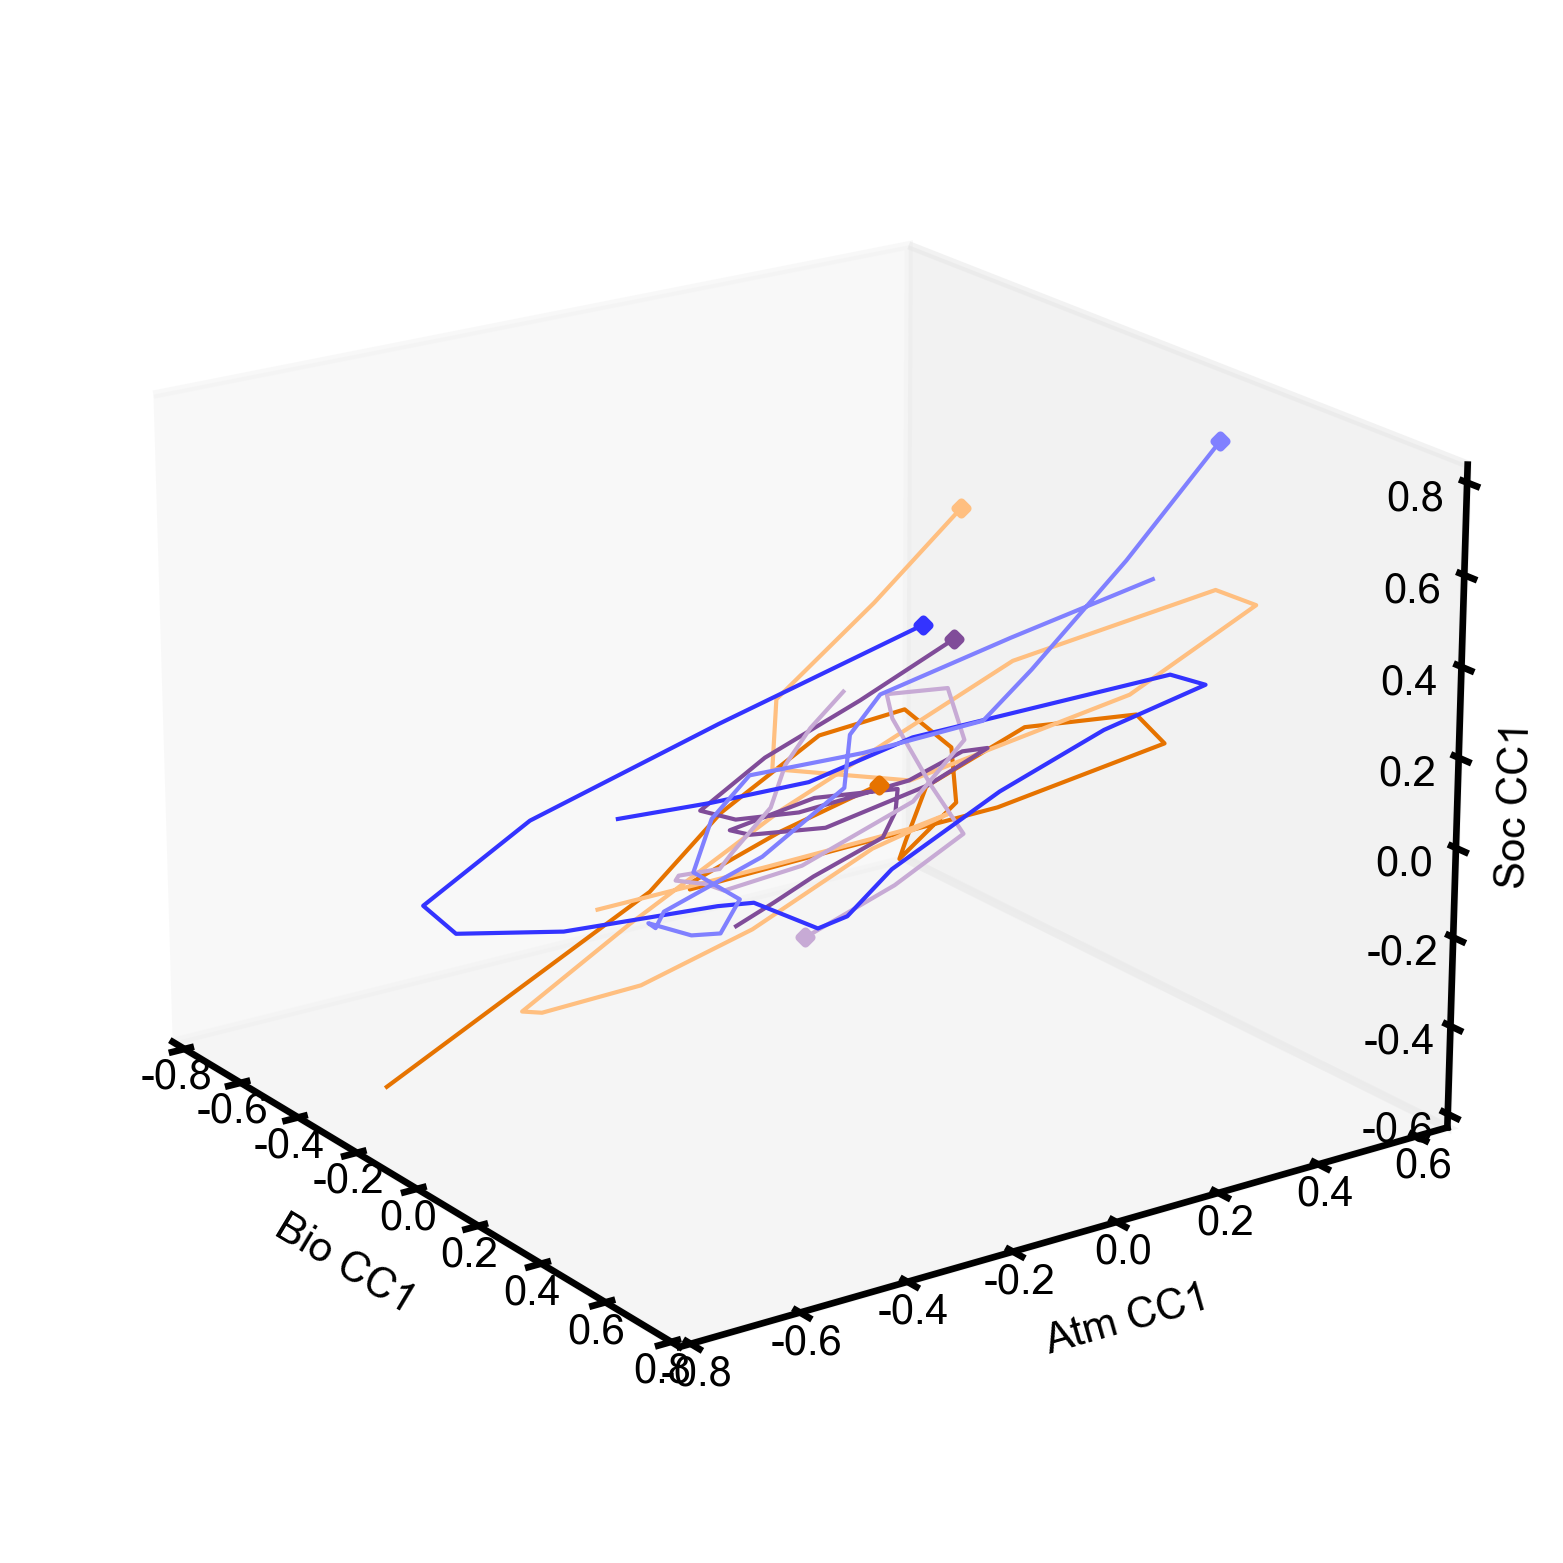

In [91]:
# read loadings of CCA components
df_final = pd.read_csv(data_path('result/CCA_components_global.csv'))[['CCX1','CCX2','CCX3','CCY1','CCY2','CCY3','CCZ1','CCZ2','CCZ3','Country Code','year']]

        
### add income and aridity
aridity = read_data(data_path('data/ERA5-land_aridity_mean_2005_2020_0d50_to_0d25.npy'))

# read datacubes
ds_new1 = xr.open_zarr(data_path("data/New_datacube_Jan.zarr")).sel(time=slice('2003-01-05', '2022-12-26'))
aridity = xr.DataArray(aridity[::-1, :], dims=("lat", "lon"), coords=dict(lat=ds_new1.lat, lon=ds_new1.lon))

aridity_country = []
shapefile = gpd.read_file(data_path("data/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp"))

# read population data and tree cover data
pop_orign = xr.open_dataset(data_path('data/gpw_v4_population_density_rev11_15_min.nc'))
POP = np.nanmean(pop_orign['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes'][0:4, ::-1, :],axis=0)  # the average of 2000, 2005, 2010, 2015
POP = xr.DataArray(POP, dims=("lat", "lon"), coords=dict(lat=ds_new1.lat, lon=ds_new1.lon))

for country in df_final['Country Code'].unique():
    aridity1 = aridity.copy()
    aridity1.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    aridity1.rio.write_crs("epsg:4326", inplace=True)
    region_shape = shapefile[shapefile['ISO3'] == country]
    clipped = aridity1.rio.clip(region_shape.geometry.apply(mapping), aridity1.rio.crs, drop=True, all_touched=True)
    aridity_country.append(clipped.mean(dim=("lat", "lon"), skipna=True))

# add income
df_income = pd.read_csv(data_path('data/world_bank_income_group.csv'))
df_final['aridity'] = np.nan
df_final['Income group'] = np.nan
for c, country in enumerate(df_final['Country Code'].unique()):
    df_final['Income group'][df_final['Country Code'] == country] = df_income['Income group'][df_income['Code'] == country].values[0]
    df_final['aridity'][df_final['Country Code'] == country] = aridity_country[c]

print(np.nanpercentile(df_final['aridity'], 50))

df_final['Income group'][df_final['Income group']=='Lower middle income'] = 'Middle income'
df_final['Income group'][df_final['Income group']=='Upper middle income'] = 'Middle income'

# add color based on income&climate
color_list = ['#e67300','#ffbf80','#804c99','#c7aad5','#3333ff', '#8080ff']

dry_ratio = 1.5
df_final['color'] = np.nan
df_final['color'][(df_final['Income group']=='Low income')&(df_final['aridity']>dry_ratio)] = color_list[0]
df_final['color'][(df_final['Income group']=='Low income')&(df_final['aridity']==np.isnan)] = color_list[0]
df_final['color'][(df_final['Income group']=='Low income')&(df_final['aridity']<=dry_ratio)] = color_list[1]
df_final['color'][(df_final['Income group']=='Middle income')&(df_final['aridity']>dry_ratio)] = color_list[2]
df_final['color'][(df_final['Income group']=='Middle income')&(df_final['aridity']==np.isnan)] = color_list[2]
df_final['color'][(df_final['Income group']=='Middle income')&(df_final['aridity']<=dry_ratio)] = color_list[3]
df_final['color'][(df_final['Income group']=='High income')&(df_final['aridity']>dry_ratio)] = color_list[4]
df_final['color'][(df_final['Income group']=='High income')&(df_final['aridity']==np.isnan)] = color_list[4]
df_final['color'][(df_final['Income group']=='High income')&(df_final['aridity']<=dry_ratio)] = color_list[5]


df_cube_show = df_final.copy()
df_cube_show['code'] = pd.factorize(df_cube_show['Country Code'])[0] + 1

var = [["CCX1", "CCY1", "CCZ1"], ["CCX2", "CCY2", "CCZ2"], ["CCX3", "CCY3", "CCZ3"]]
xlim = [[-1, 1], [-1, 1], [-1.2, 1.2]]
ylim = [[-1.5, 1.5], [-1, 1], [-1.5, 1.5]]
zlim = [[-1.5, 1.5], [-0.8, 0.8], [-2, 2]]
xticks = [[-0.8, 0, 0.8], [-0.8, 0, 0.8], [-1, 0, 1]]
yticks = [[-1.3, 0, 1.3], [-0.8, 0, 0.8], [-1, 0, 1]]
zticks = [[-1.3, 0, 1.3], [-0.6, 0, 0.6], [-1.5, 0, 1.5]]

fig = plt.figure(figsize=(10, 10), dpi=600, tight_layout=False)
ax = fig.add_subplot(4, 2, 1, projection='3d')
compo=0
for cluster_color in color_list:
    for domain in [0, 1, 2]:
        data = []
        for y in range(2003, 2023, 1):
            df = df_cube_show[[var[compo][domain], 'year', 'color']]
            median = df[var[compo][domain]].loc[(df['year'] == y) & (df['color'] == cluster_color)].median()
            data.append(median)

        yearlist = np.arange(0, len(data), 1)
        data_smooth = lowess(data, yearlist, frac=0.3)[:, 1]

        if domain == 0:
            pos00 = data_smooth
        if domain == 1:
            pos01 = data_smooth
        if domain == 2:
            pos02 = data_smooth

    ax.plot(pos00, pos01, pos02,c=cluster_color, linewidth=0.5)
    ax.scatter(pos00[-1], pos01[-1], pos02[-1], edgecolors=None, c=cluster_color, marker="D", s=1)

    # ax.set_xlim(xlim[compo])
    # ax.set_ylim(ylim[compo])
    # ax.set_zlim(zlim[compo])
    # ax.set_xticks(xticks[compo])
    # ax.set_yticks(yticks[compo])
    # ax.set_zticks(zticks[compo])

    ax.set_xlabel(["Bio CC1", "Bio CC2", "Bio CC3"][compo])
    ax.set_ylabel(["Atm CC1", "Atm CC2", "Atm CC3"][compo])
    ax.set_zlabel(["Soc CC1", "Soc CC2", "Soc CC3"][compo])
    ax.view_init(elev=20., azim=-35, roll=0)
    ax.tick_params(axis='x', pad=-7)
    ax.xaxis.labelpad = -13
    ax.tick_params(axis='y', pad=-7)
    ax.yaxis.labelpad = -13
    ax.tick_params(axis='z', pad=-11.5)
    ax.zaxis.labelpad = -17
    ax.grid(False)
    
plt.setp(ax.spines.values(), lw=0.2)
plt.subplots_adjust(hspace=-0.1, wspace=-0.02)

# plt.savefig(data_path('figure/fig.CCA_3axes_trends.jpg'),bbox_inches='tight')


# Manuscript Figure 5A-B: Top-down extreme detection

Dim 1
0 2021 Afghanistan
1 2011 Angola
2 2022 France
3 2022 Guyana
4 2015 Indonesia
5 2021 Iran (Islamic Republic of)
6 2022 Kiribati
7 2005 Malawi
8 2009 Nepal
9 2004 Pakistan
10 2021 Pakistan
11 2015 Poland
12 2010 Timor-Leste
13 2019 United States
14 2011 Saint Vincent and the Grenadines
15 2022 Samoa
16 2005 Zambia
Dim 2
0 2007 Albania
1 2022 Cameroon
2 2010 Czech Republic
3 2016 Algeria
4 2021 Hong Kong
5 2008 Honduras
6 2020 India
7 2019 Iran (Islamic Republic of)
8 2019 Iraq
9 2015 Jamaica
10 2012 Lao People's Democratic Republic
11 2022 Lebanon
12 2018 Morocco
13 2011 Namibia
14 2022 Paraguay
15 2004 Solomon Islands
16 2022 Vanuatu
17 2022 South Africa


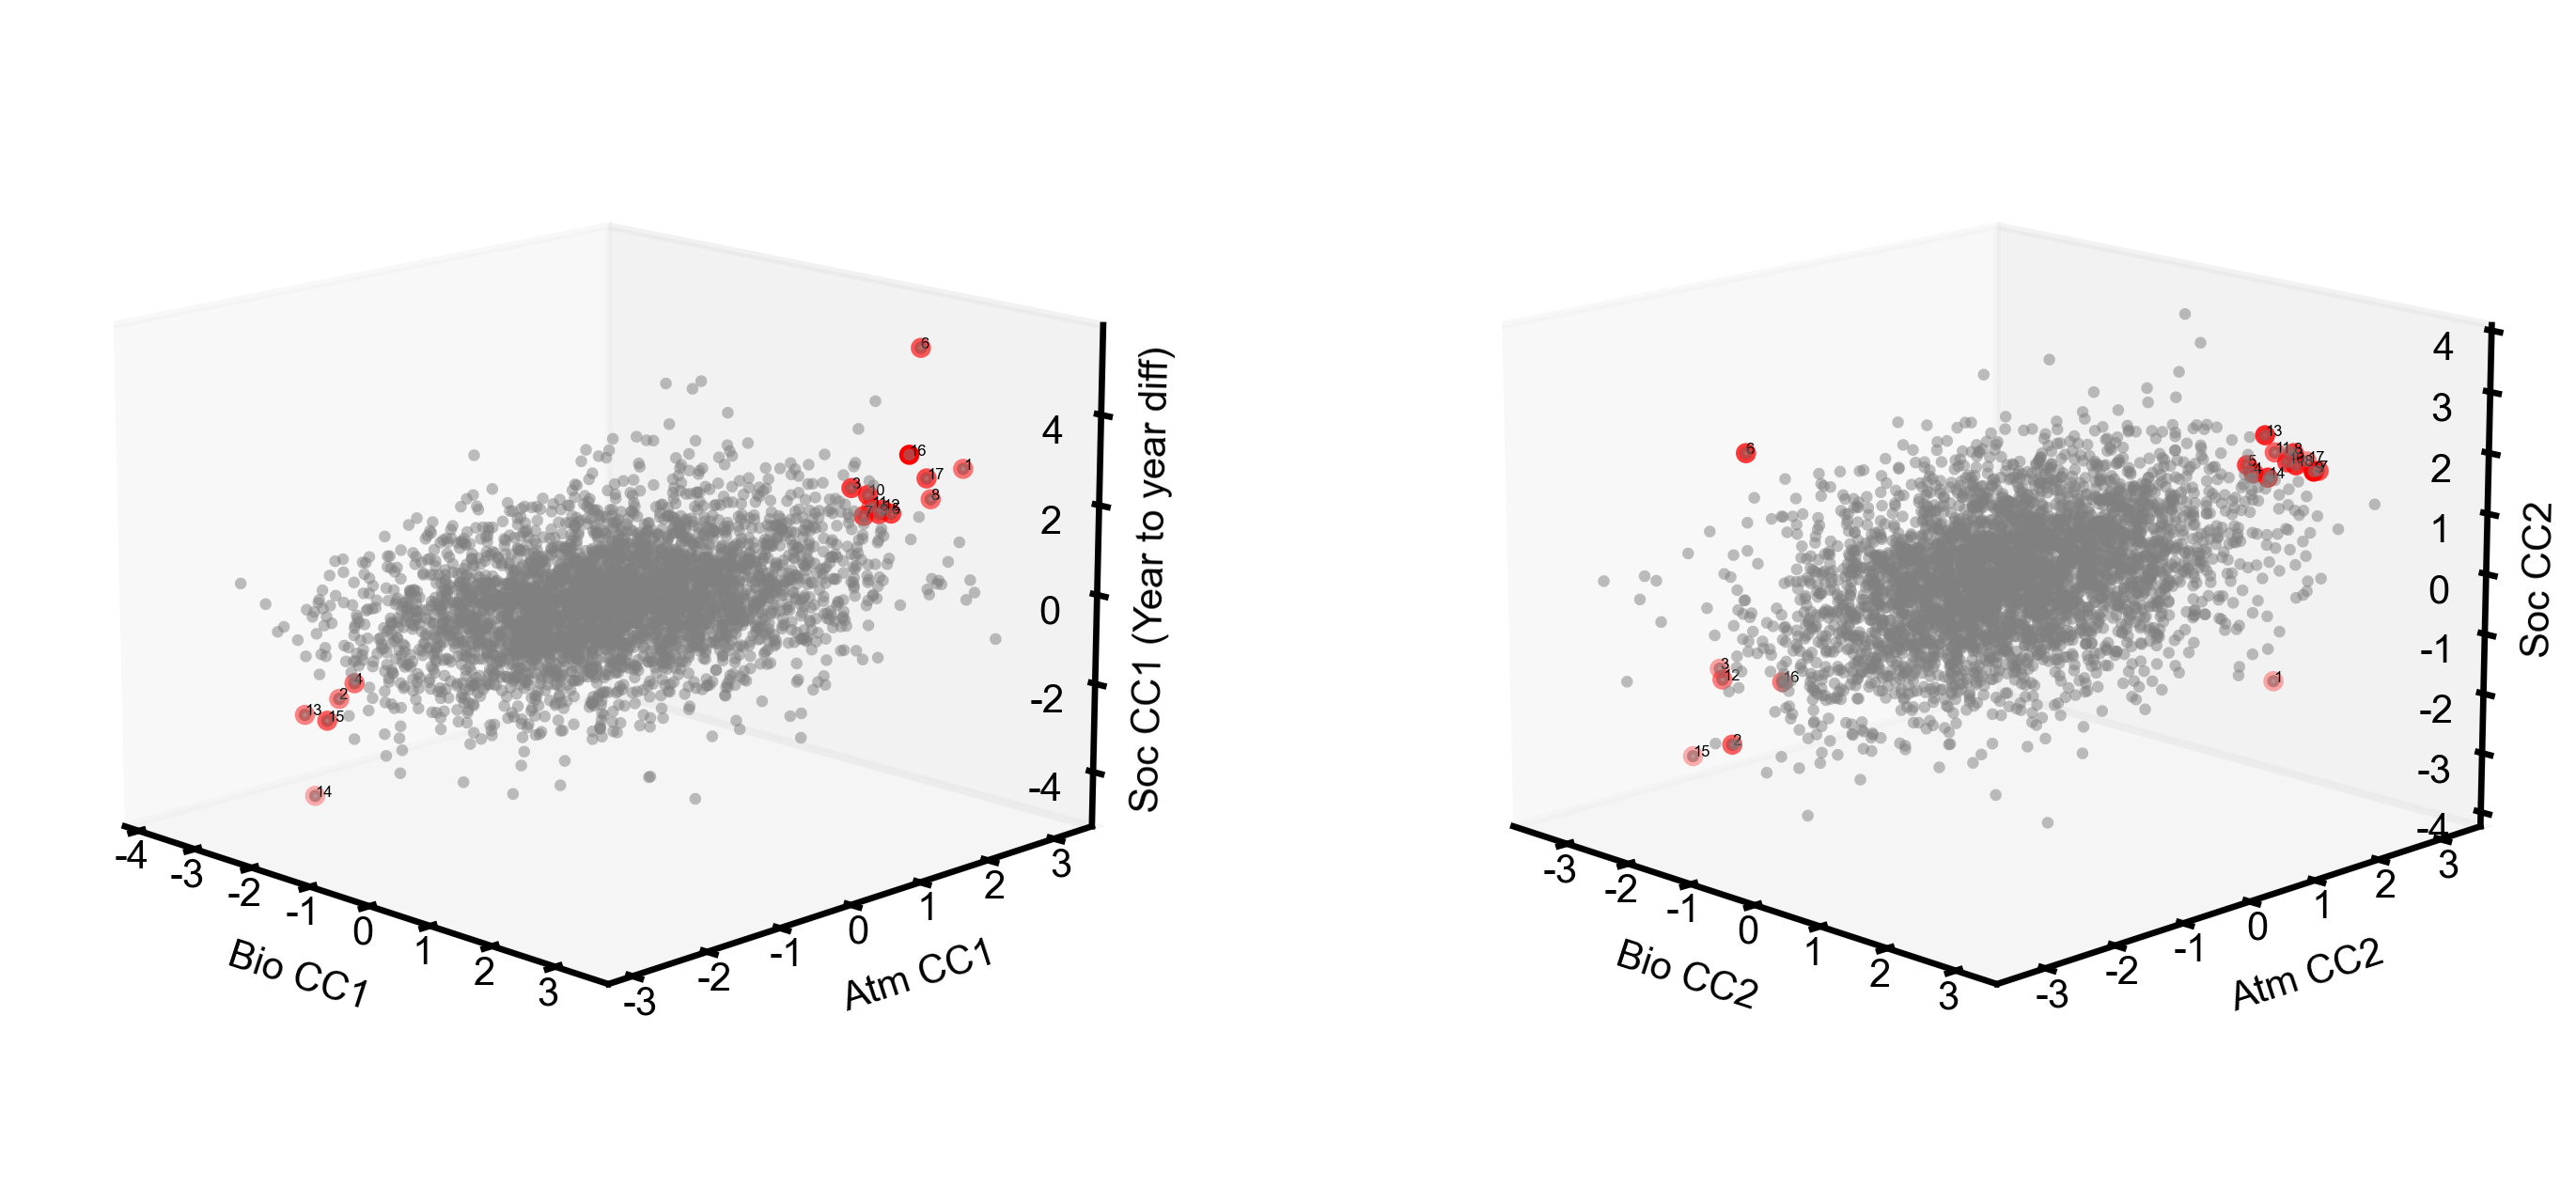

<Figure size 640x480 with 0 Axes>

In [97]:
# read loadings of CCA components
df_CCA = pd.read_csv(data_path('result/CCA_components_global.csv'))[['CCX1','CCX2','CCX3','CCY1','CCY2','CCY3','CCZ1','CCZ2','CCZ3']]

data_standard1_list = []
for c in range(187):
    scaled_data = StandardScaler().fit_transform(df_CCA[c * 20:c * 20 + 20])
    data_standard1_list.append(pd.DataFrame(scaled_data))
data_standard1 = pd.concat(data_standard1_list, ignore_index=True)

data_standard1.columns = (df_CCA.columns)

df_CCA_final = pd.concat([data_standard1, df_standard['Country Code'], df_standard['year']], axis=1)
shapefile = gpd.read_file(data_path("data/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp"))

### plot extreme distribution
xlim = [[-3,3],[-3,3]]
ylim = [[-3,3],[-3,3]]
zlim = [[-2.5,2.5],[-3,3]]
xticks = [[-2.5,0,2.5],[-2.5,0,2.5],[-2.5,0,2.5]]
yticks = [[-2.5,0,2.5],[-2.5,0,2.5],[-2.5,0,2.5]]
zticks = [[-2,0,2],[-2.5,0,2.5],[-2.5,0,2.5]]
var = [["CCX1", "CCY1", "CCZ1"], ["CCX2", "CCY2", "CCZ2"], ["CCX3", "CCY3", "CCZ3"]]

### DATA
fig = plt.figure(figsize=(5, 8), dpi=600, tight_layout=False)
for v in range(2):
    ax = fig.add_subplot(4, 2, 1+v, projection='3d')
    ax.view_init(elev=[15, 15][v], azim=[-45, -45][v], roll=[0, 0][v])
    ax.tick_params(axis='x', pad=-7)
    ax.xaxis.labelpad = -13
    ax.tick_params(axis='y', pad=-7)
    ax.yaxis.labelpad = -13
    ax.tick_params(axis='z', pad=-11.5)
    ax.zaxis.labelpad = -17
    ax.grid(False)
    # ax.set_zlim(zlim[v])
    # ax.set_zticks(zticks[v])
    ax.set_xlabel(["Bio CC1","Bio CC2","Bio CC3"][v])
    ax.set_ylabel(["Atm CC1","Atm CC2","Atm CC3"][v])
    ax.set_zlabel(["Soc CC1 (Year to year diff)","Soc CC2","Soc CC3"][v])
    # ax.set_xlim(xlim[v])
    # ax.set_ylim(ylim[v])
    # ax.set_xticks(xticks[v])
    # ax.set_yticks(yticks[v])

    plt.setp(ax.spines.values(), lw=0.2)
    plt.subplots_adjust(hspace=-0.1, wspace=-0.02)


    if v==0:
        print('Dim 1')
        XX, YY = df_CCA_final[var[v][0]].values, df_CCA_final[var[v][1]].values
        ZZ = df_CCA_final[var[v][2]] - df_CCA_final.groupby(['Country Code'])[var[v][2]].shift(1)
        ZZ = ZZ.values
    if v==1:
        print('Dim 2')
        XX, YY, ZZ = df_CCA_final[var[v][0]].values, df_CCA_final[var[v][1]].values, df_CCA_final[var[v][2]].values

    ax.scatter(XX, YY, ZZ, edgecolors='grey', c='grey', marker='.', s=1, alpha=0.5)

    # # social extreme events: 99th, plotting if x and y are extremes
    ind_extreme = np.where(((XX < np.nanpercentile(XX, 5)) | (XX > np.nanpercentile(XX, 95))) & ((YY < np.nanpercentile(ZZ, 5)) | (YY > np.nanpercentile(YY, 95))) & ((ZZ < np.nanpercentile(ZZ, 5)) | (ZZ > np.nanpercentile(ZZ, 95))))
    c=0
    for ind in ind_extreme[0]:
        country_code = df_CCA_final[['Country Code']].loc[ind].values[0]
        print(c,int(df_CCA_final['year'].loc[ind]), shapefile['NAME'][shapefile['ISO3']==country_code].values[0])
        c=c+1

    XX_1th_99th = XX[ind_extreme]
    YY_1th_99th = YY[ind_extreme]
    ZZ_1th_99th = ZZ[ind_extreme]
    ax.scatter(XX_1th_99th, YY_1th_99th, ZZ_1th_99th, edgecolors='red', c='red', marker='.', s=10)
    for event in range(np.shape(ind_extreme[0])[0]):
        ax.text(XX_1th_99th[event], YY_1th_99th[event], ZZ_1th_99th[event], str(event+1), color='black', fontsize=2)

plt.show()
# plt.savefig(data_path('figure/fig5.extreme_detection.jpg'),bbox_inches='tight')


# Manuscript Figure 5C-: Cases of country extremes

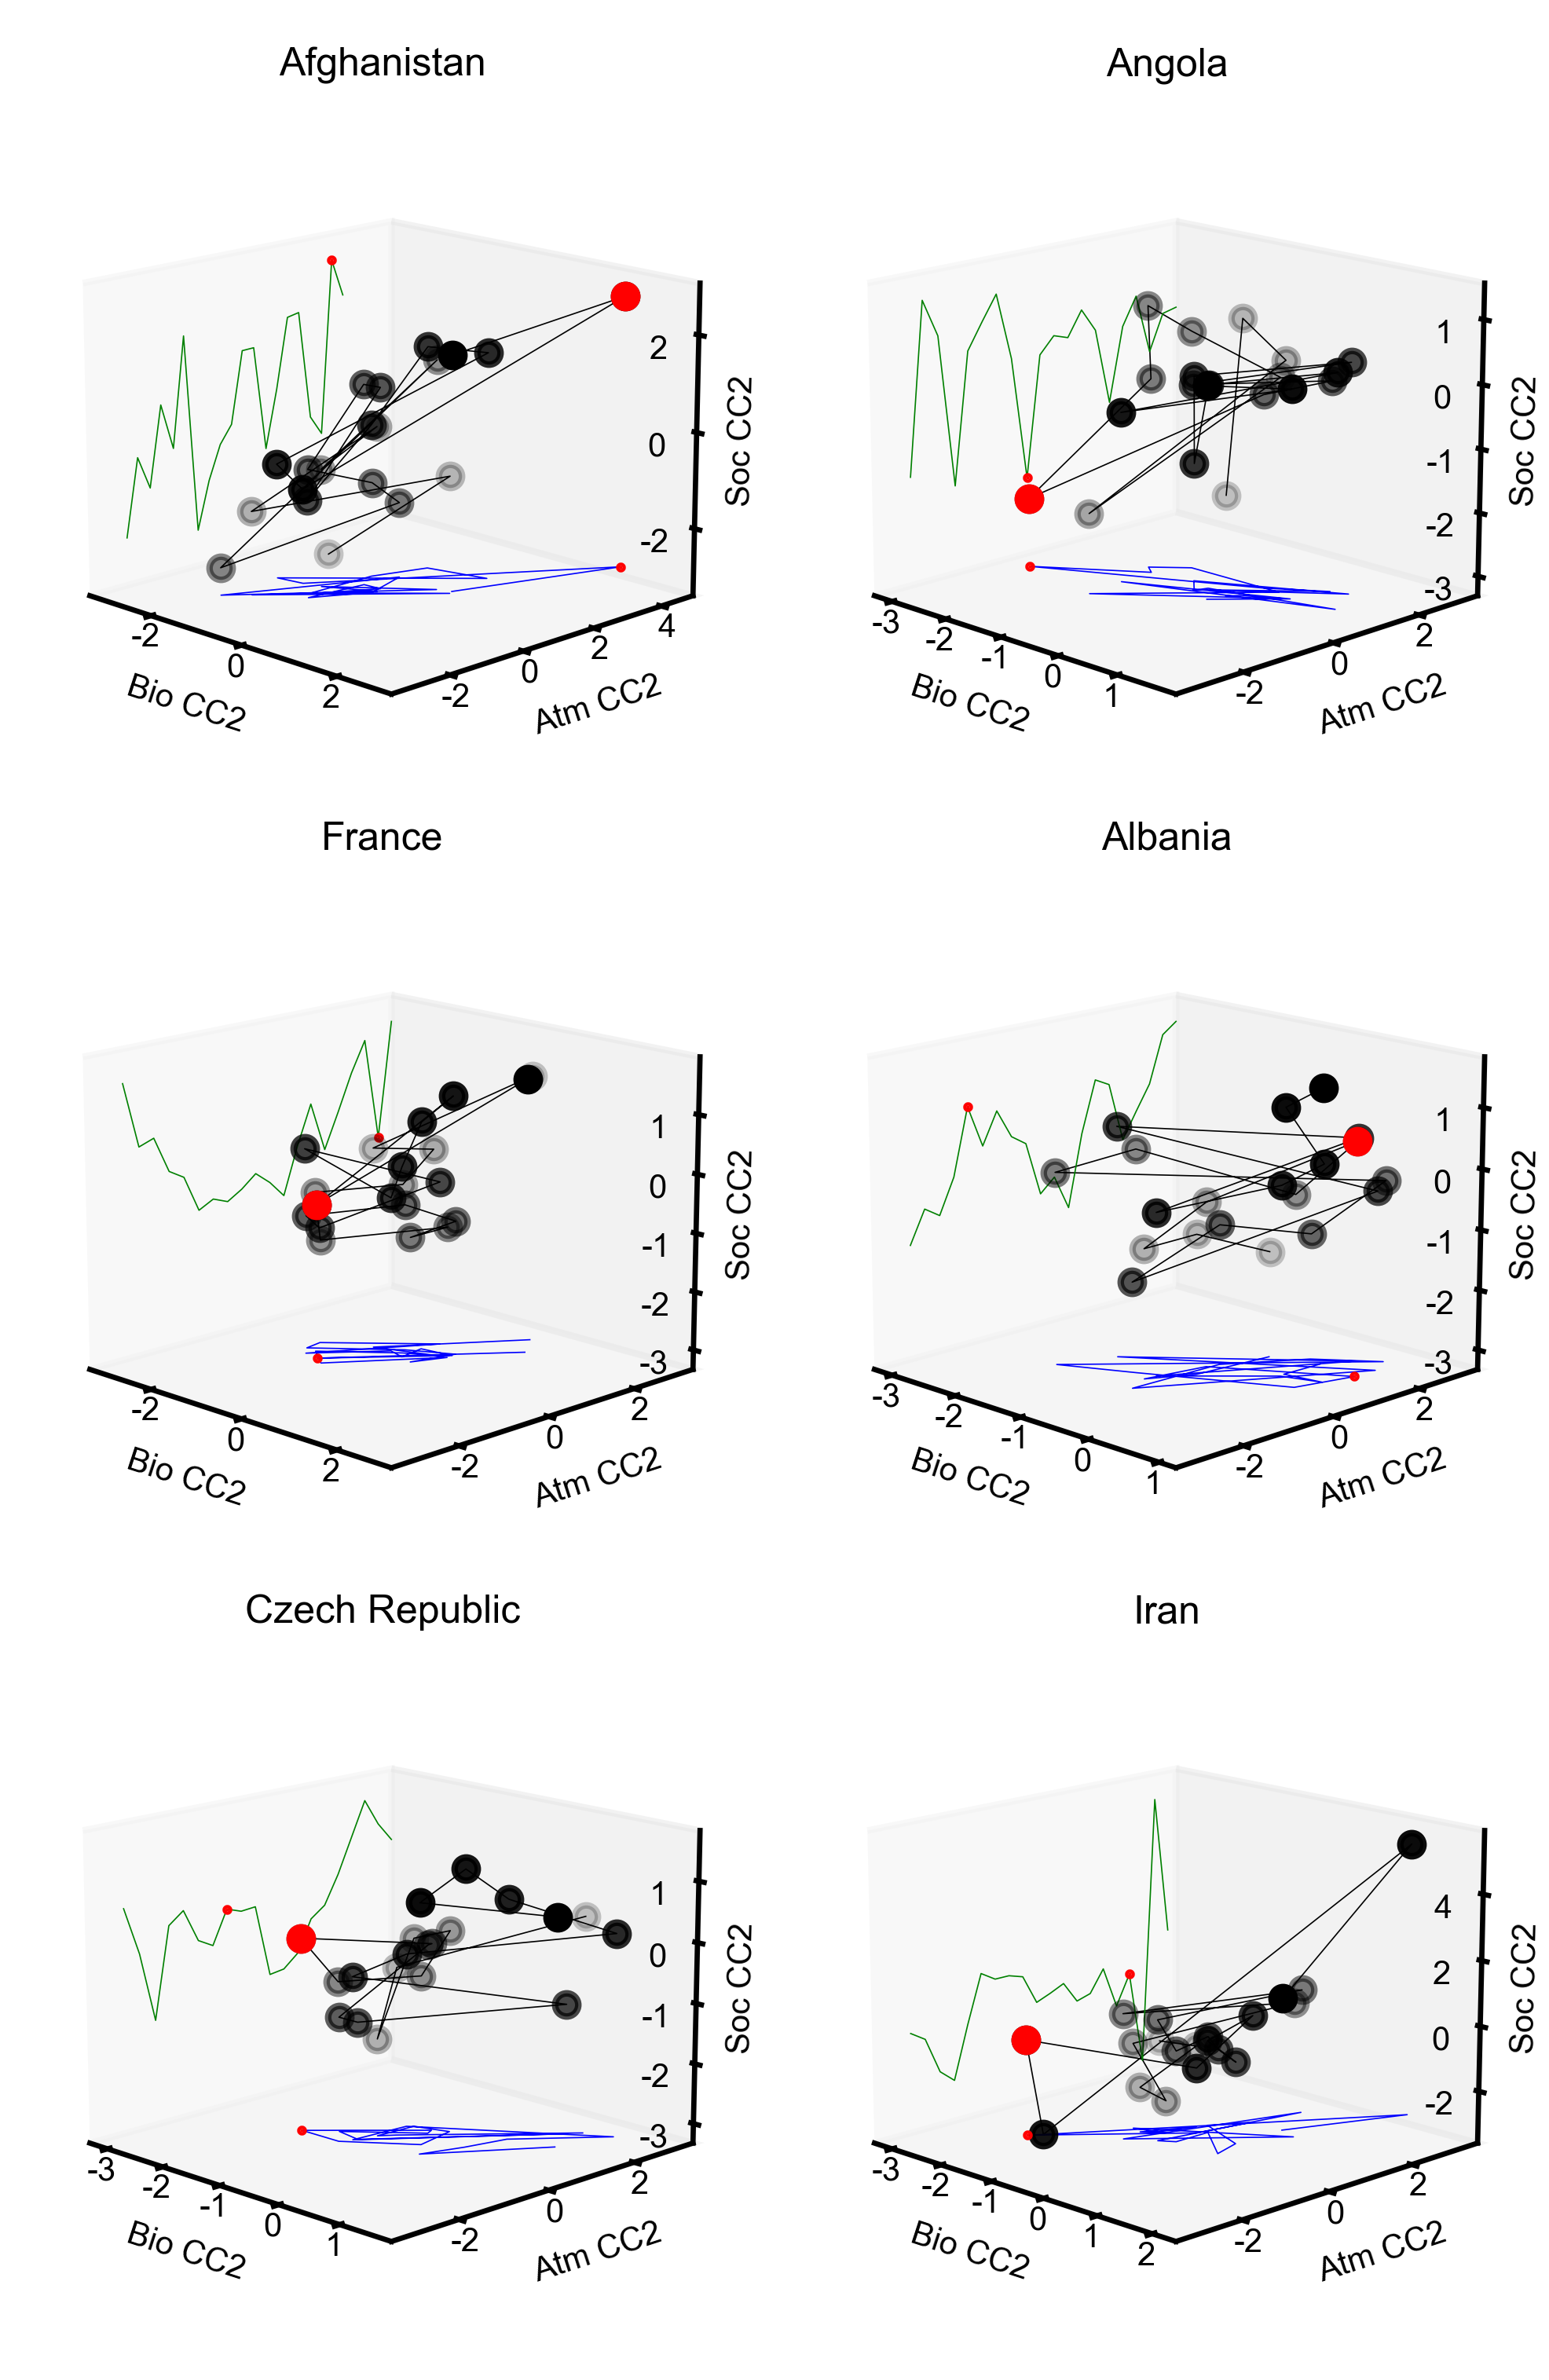

In [96]:
# read loadings of CCA components
df_CCA = pd.read_csv(data_path('result/CCA_components_global.csv'))[['CCX1','CCX2','CCX3','CCY1','CCY2','CCY3','CCZ1','CCZ2','CCZ3','Country Code','year']]

# event_year = [[2017],[2015],[2019]]
# event_year = [[2015],[2005],[2019]]
event_year = [[2021],[2011],[2021],[2007],[2010],[2019]]
event_color = 'red'
# country_list = ['NER', 'VUT', 'AUS']
# country_name = ['Niger', 'Vanuatu', 'Australia']
# country_list = ['IDN', 'MWI', 'POL']
# country_name = ['Indonesia', 'Malawi', 'Poland']
country_list = ['AFG', 'AGO', 'FRA', 'ALB', 'CZE', 'IRN']
country_name = ['Afghanistan', 'Angola', 'France', 'Albania', 'Czech Republic', 'Iran']
elev_list = 15.

var = ["CCX1", "CCY1", "CCZ1"]
xticks = [[-2.5,0,2.5],[-2.5,0,2.5],[-2.5,0,2.5]]
yticks = [[-2.5,0,2.5],[-2.5,0,2.5],[-2.5,0,2.5]]
zticks = [[-2.5,0,2.5],[-2.5,0,2.5],[-2.5,0,2.5]]
xlim = [[-3,3],[-3,3],[-3,3]]
ylim = [[-3,3],[-3,3],[-3,3]]
zlim = [[-3,3],[-3,3],[-3,3]]

fig = plt.figure(figsize=(5, 5), dpi=600, tight_layout=False)

for country, country1, v in zip(country_list, country_name, range(6)):
    if country=='AFG' or 'AGO' or 'FRA':
        compo = 0
    if country=='ALB' or 'CZE' or 'IRN':
        compo = 1
    
    c = 0
    data = df_CCA[df_CCA['Country Code']==country]
    ax = fig.add_subplot(3, 2, v+1, projection='3d')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

    # 2D projection
    xx, yy, zz = data[var[0]].values, data[var[1]].values, data[var[2]].values
    ax.plot(xx,yy,zz,color='black', linewidth=0.2)
    ax.plot(xx, yy, zs=-3, zdir='z', color='blue', linewidth=0.2) # xy projection

    z_diff = [0]
    for i in range(19):
        z_diff.append(zz[i+1]-zz[i])

    if compo==0:
        ax.plot(np.linspace(-3,3,20), z_diff, zs=-3, zdir='x', color='green', linewidth=0.2) # z_diff
    else:
        ax.plot(np.linspace(-3,3,20), zz, zs=-3, zdir='x', color='green', linewidth=0.2) # z


    # 3D plot
    for y in range(2003, 2023, 1):
        pos00 = data[var[0]].loc[data['year'] == y].values[0]
        pos01 = data[var[1]].loc[data['year'] == y].values[0]
        pos02 = data[var[2]].loc[data['year'] == y].values[0]

        ax.scatter(pos00, pos01, pos02,edgecolors=None,c='black', alpha=(y-1998)/(2022-1998), marker='.', s=50)
        if y in event_year[v]:
            ax.scatter(pos00, pos01, pos02,edgecolors=None,c=event_color, marker='.', s=50) #main
            ax.scatter(pos00, pos01, zs=-3, zdir='z',edgecolors=None, color=event_color, marker='.', s=1) #xy

            z_diff_x = np.linspace(-3,3,20)[y-2003]
            z_diff_y = data[var[2]].loc[data['year'] == y].values[0] - data[var[2]].loc[data['year'] == y-1].values[0]

            if compo==0:
                ax.scatter(z_diff_x, z_diff_y, zs=-3, zdir='x',edgecolors=None, color=event_color, marker='.', s=1) #z_diff
            else:
                ax.scatter(z_diff_x, pos02, zs=-3, zdir='x',edgecolors=None, color=event_color, marker='.', s=1) #z
            c = c + 1


            ax.view_init(elev=elev_list, azim=-45, roll=0)


        # ax.set_xlim(xlim[compo])
        # ax.set_ylim(ylim[compo])
        # ax.set_zlim(zlim[compo])
        # ax.set_xticks(xticks[compo])
        # ax.set_yticks(yticks[compo])
        # ax.set_zticks(zticks[compo])

        ax.set_xlabel(["Bio CC1","Bio CC2","Bio CC3"][compo])
        ax.set_ylabel(["Atm CC1","Atm CC2","Atm CC3"][compo])
        ax.set_zlabel(["Soc CC1","Soc CC2","Soc CC3"][compo])
        ax.tick_params(axis='x', pad=-7)
        ax.xaxis.labelpad = -13
        ax.tick_params(axis='y', pad=-7)
        ax.yaxis.labelpad = -13
        ax.tick_params(axis='z', pad=-11.5)
        ax.zaxis.labelpad = -17
        ax.grid(False)
        ax.set_title(country1)
plt.setp(ax.spines.values(), lw=0.2)
plt.subplots_adjust(hspace=-0.1,wspace=-0.02)


# plt.savefig(data_path('figure/fig5.extreme_examples.jpg'),bbox_inches='tight')


# Plot these extreme events with original data

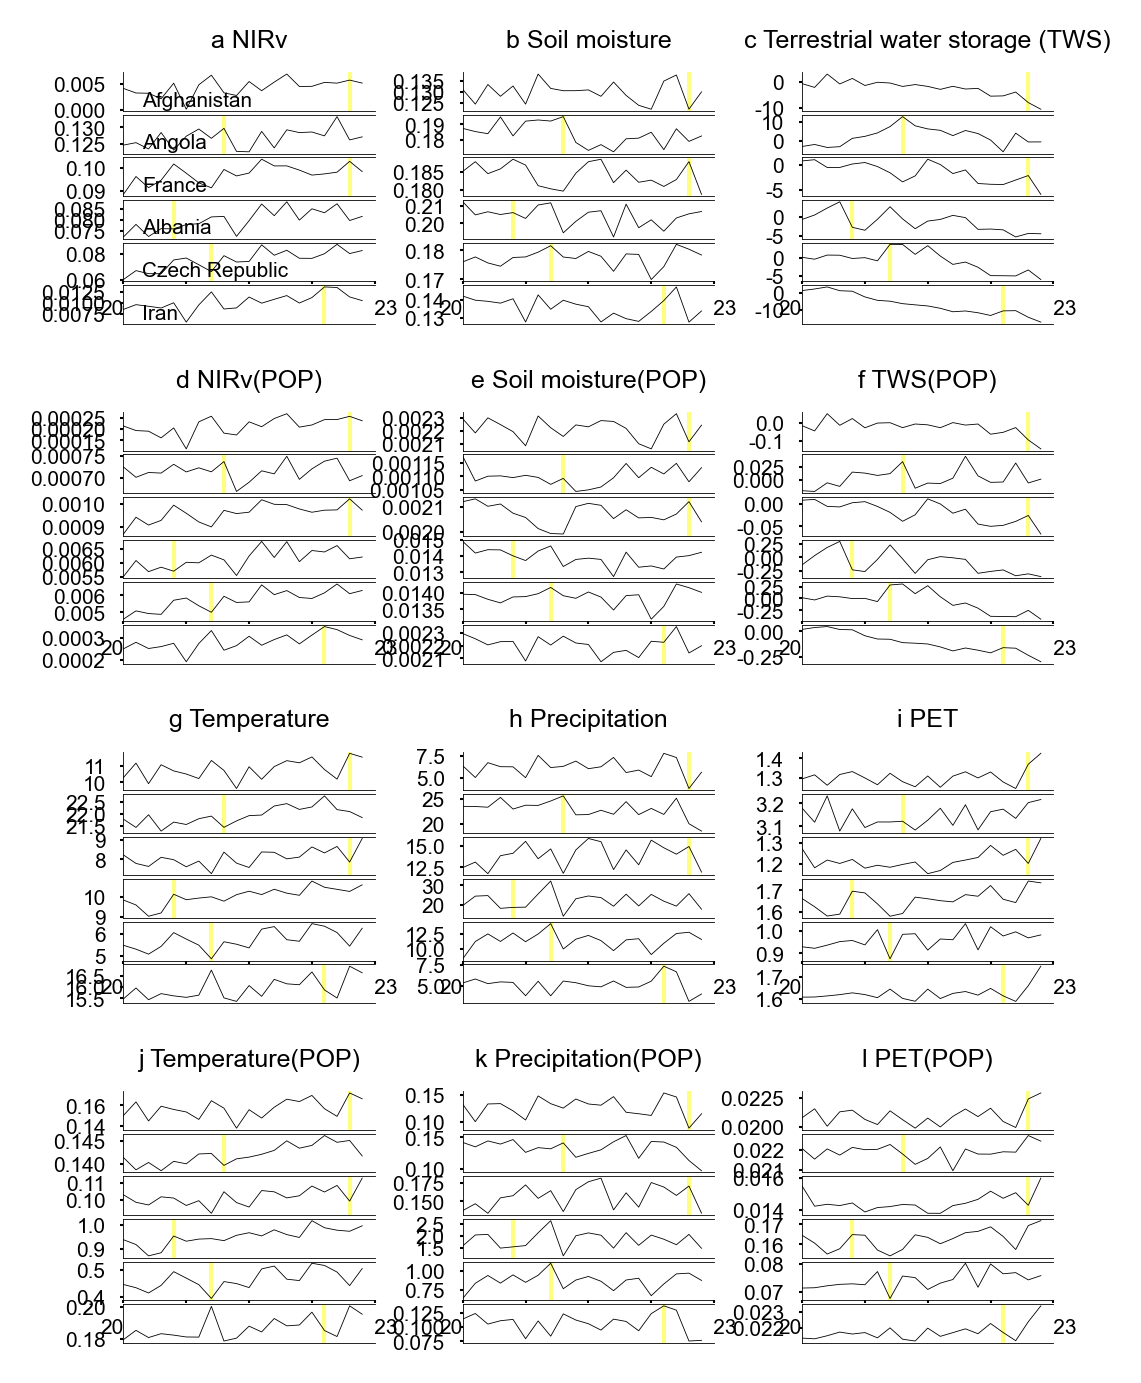

In [ ]:
############# read original data
WDI_df = pd.read_csv(data_path('data/WDI_2003_2022.csv'))
WDI_df_new = pd.read_csv(data_path('data/WDI_2003_2022_flaged_transpose.csv'))
WDI_df_new[['year', 'remove']] = WDI_df_new['year'].str.split(' ', n=1, expand=True)
WDI_df_new['year'] = WDI_df_new['year'].astype(int)
WDI_df_new['Country Code'] = WDI_df_new['Country Code']
WDI_df_new = WDI_df_new.drop(columns=['Unnamed: 0','Unnamed: 24', 'remove', 'Country Code', 'year'])
sio_var = WDI_df_new.columns.values.tolist()

df_bio_atm_sio1 = pd.read_csv(data_path('data/df_all_annual_noweight_newDec2024.csv'))
df_bio_atm_sio1 = df_bio_atm_sio1.drop(columns=['Unnamed: 0'])
df_bio_atm_sio2 = pd.read_csv(data_path('data/df_all_annual_weightbyPOP_newDec2024.csv'))
df_bio_atm_sio2 = df_bio_atm_sio2.drop(columns=['Unnamed: 0','year','Country Code'])
df_bio_atm_sio2.columns = [str(col) + '_weightedbyPOP' for col in df_bio_atm_sio2.columns]

### fit interpolate with linear method
df_bio_atm_sio = pd.concat([df_bio_atm_sio1, df_bio_atm_sio2], axis=1)

var_abr = ["nirv", "sm", "tws",
       "nirv_weightedbyPOP", "sm_weightedbyPOP", "tws_weightedbyPOP",
       "t2m", "tp", "PET",
       "t2m_weightedbyPOP", "tp_weightedbyPOP", "PET_weightedbyPOP"]

var = ["NIRv", "Soil moisture", "Terrestrial water storage (TWS)",
       "NIRv(POP)", "Soil moisture(POP)", "TWS(POP)",
       "Temperature", "Precipitation", "PET",
       "Temperature(POP)", "Precipitation(POP)", "PET(POP)"]

shapefile = gpd.read_file(data_path('data/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp'))
shapefile_new = shapefile[shapefile['ISO3'].isin(np.unique(df_bio_atm_sio['Country Code']))].reset_index(drop=True)
color = 'black'
ylim = [[-0.2,0.2],[-0.01,0.01],[-0.12,0.12],
        [-0.5,0.5],[-0.7,0.7],[-0.2,0.2],
        [-15,15],[-0.01,0.01]]

fig = plt.figure(figsize=(4, 5.5), dpi=300, tight_layout=False)
gs   = gridspec.GridSpec(4, 3, hspace=0.35, wspace=0.35)

for x in range(12):
    gs01 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[x], hspace=0.1)

    for country, country1, v in zip(['AFG', 'AGO', 'FRA', 'ALB', 'CZE', 'IRN'], ['Afghanistan', 'Angola', 'France', 'Albania', 'Czech Republic', 'Iran'], range(6)):
        ax = fig.add_subplot(gs01[v])
        df_show = df_bio_atm_sio.loc[df_bio_atm_sio['Country Code'] == country]  # 'DEU', 'CHN'

        ax.axvline(x=[2021,2011,2021,2007,2010,2019][v], color='yellow', alpha=0.5)
        # ax.axvline(x=2009, color='lightgrey')
        # ax.axvline(x=2012, color='lightgrey')
        # ax.axvspan(2013, 2014, facecolor='lightgrey', alpha=0.5)
        # ax.axvline(x=2019, color='lightgrey', alpha=0.5)
        ax.plot(df_show['year'], df_show[var_abr[x]].values, c=color, label=country1, linewidth=0.2)
        plt.setp(ax.spines.values(), lw=0.2)


        ax.set_xlim([2003,2020])
        ax.set_xticks([2003, 2008, 2013, 2018, 2023])
        ax.xaxis.set_tick_params(length=0.8, width=0.5, which='major')
        ax.yaxis.set_tick_params(length=0.8, width=0.5, which='major')


        if v == 0:
            ax.set_title(['a ','b ','c ','d ','e ','f ','g ','h ','i ','j ','k ','l '][x]+var[x])
            ax.spines[['right', 'top']].set_visible(False)
        if x==0:
            leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc='upper left', frameon=False)
            for item in leg.get_lines():
                item.set_visible(False)
            # ax.legend()

        if v != 4:
            ax.get_xaxis().set_visible(False)

        ax.xaxis.set_tick_params(length=0.8, width=0.5, which='major')
        ax.yaxis.set_tick_params(length=0.8, width=0.5, which='major')
        plt.setp(ax.spines.values(), lw=0.2)
        ax.spines[['right']].set_visible(False)

plt.subplots_adjust(hspace=0,wspace=0.2)
# plt.savefig(data_path('figure/fig.multivariate_example_pick_bioatm.jpg'),bbox_inches='tight')


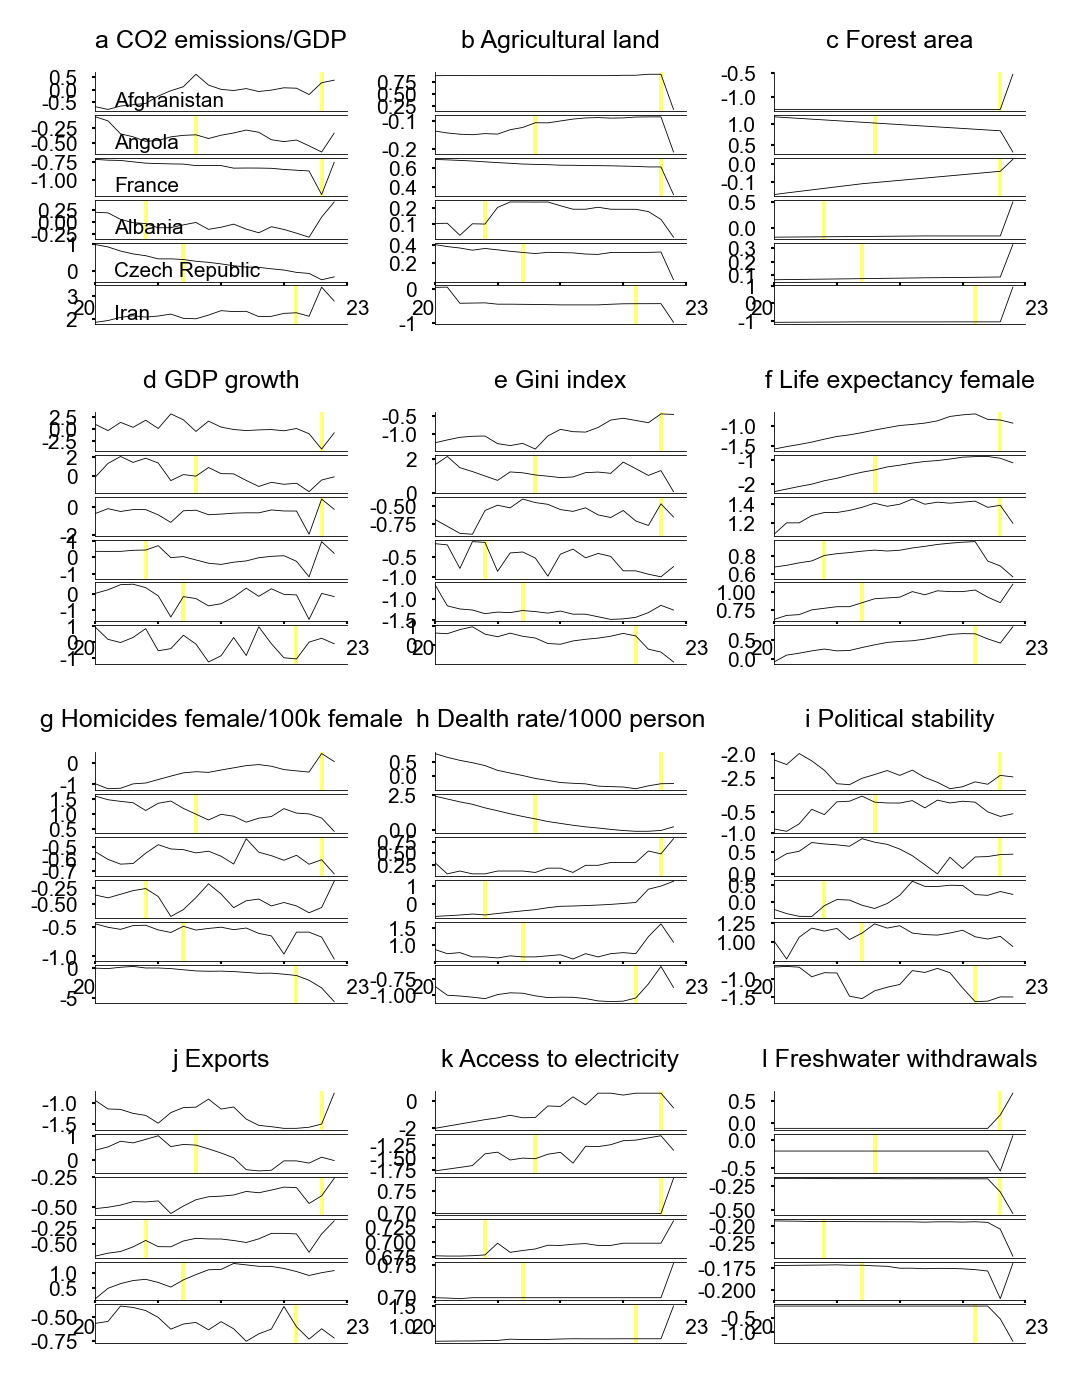

In [95]:
############# read original data
df_bio_atm_sio = pd.read_csv(data_path('data/df_all_annual_normal_global.csv'))

var_abr = ["EN.ATM.CO2E.KD.GD", "AG.LND.AGRI.ZS", "AG.LND.FRST.ZS",
           "NY.GDP.MKTP.KD.ZG", "SI.POV.GINI", "SP.DYN.LE00.FE.IN",
       "VC.IHR.PSRC.FE.P5", "SP.DYN.CDRT.IN", "PV.EST",
       "NE.EXP.GNFS.ZS", "EG.ELC.ACCS.ZS", "ER.H2O.FWTL.ZS"
       ]

var = ["CO2 emissions/GDP", "Agricultural land", "Forest area",
       "GDP growth", "Gini index", "Life expectancy female",
       "Homicides female/100k female", "Dealth rate/1000 person", "Political stability",
       "Exports", "Access to electricity", "Freshwater withdrawals"
       ]

shapefile = gpd.read_file(data_path('data/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp'))
shapefile_new = shapefile[shapefile['ISO3'].isin(np.unique(df_bio_atm_sio['Country Code']))].reset_index(drop=True)
color = 'black'
ylim = [[-0.2,0.2],[-0.01,0.01],[-0.12,0.12],
        [-0.5,0.5],[-0.7,0.7],[-0.2,0.2],
        [-15,15],[-0.01,0.01]]

fig = plt.figure(figsize=(4, 5.5), dpi=300, tight_layout=False)
gs   = gridspec.GridSpec(4, 3, hspace=0.35, wspace=0.35)

for x in range(12):
    gs01 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[x], hspace=0.1)

    for country, country1, v in zip(['AFG', 'AGO', 'FRA', 'ALB', 'CZE', 'IRN'], ['Afghanistan', 'Angola', 'France', 'Albania', 'Czech Republic', 'Iran'], range(6)):
        ax = fig.add_subplot(gs01[v])
        df_show = df_bio_atm_sio.loc[df_bio_atm_sio['Country Code'] == country] 

        ax.axvline(x=[2021,2011,2021,2007,2010,2019][v], color='yellow', alpha=0.5)
        # ax.axvline(x=2009, color='lightgrey')
        # ax.axvline(x=2012, color='lightgrey')
        # ax.axvspan(2013, 2014, facecolor='lightgrey', alpha=0.5)
        # ax.axvline(x=2019, color='lightgrey', alpha=0.5)
        ax.plot(df_show['year'], df_show[var_abr[x]].values, c=color, label=country1, linewidth=0.2)
        plt.setp(ax.spines.values(), lw=0.2)


        ax.set_xlim([2003,2020])
        ax.set_xticks([2003, 2008, 2013, 2018, 2023])
        ax.xaxis.set_tick_params(length=0.8, width=0.5, which='major')
        ax.yaxis.set_tick_params(length=0.8, width=0.5, which='major')


        if v == 0:
            ax.set_title(['a ','b ','c ','d ','e ','f ','g ','h ','i ','j ','k ','l '][x]+var[x])
            ax.spines[['right', 'top']].set_visible(False)
        if x==0:
            leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc='upper left', frameon=False)
            for item in leg.get_lines():
                item.set_visible(False)
            # ax.legend()

        if v != 4:
            ax.get_xaxis().set_visible(False)

        ax.xaxis.set_tick_params(length=0.8, width=0.5, which='major')
        ax.yaxis.set_tick_params(length=0.8, width=0.5, which='major')
        plt.setp(ax.spines.values(), lw=0.2)
        ax.spines[['right']].set_visible(False)

plt.subplots_adjust(hspace=0,wspace=0.2)
# plt.savefig(data_path('figure/fig.multivariate_example_pick_soc.jpg'),bbox_inches='tight')
